Iniciando Análisis Exploratorio de Datos de Imágenes...
Fecha y hora de ejecución: 2025-05-18 17:34:52 (UTCNone)
Se encontraron 3478 imágenes en 'Complete_Bimbo/Fotos Chambita 1364'.

Mostrando 5 imágenes de muestra:


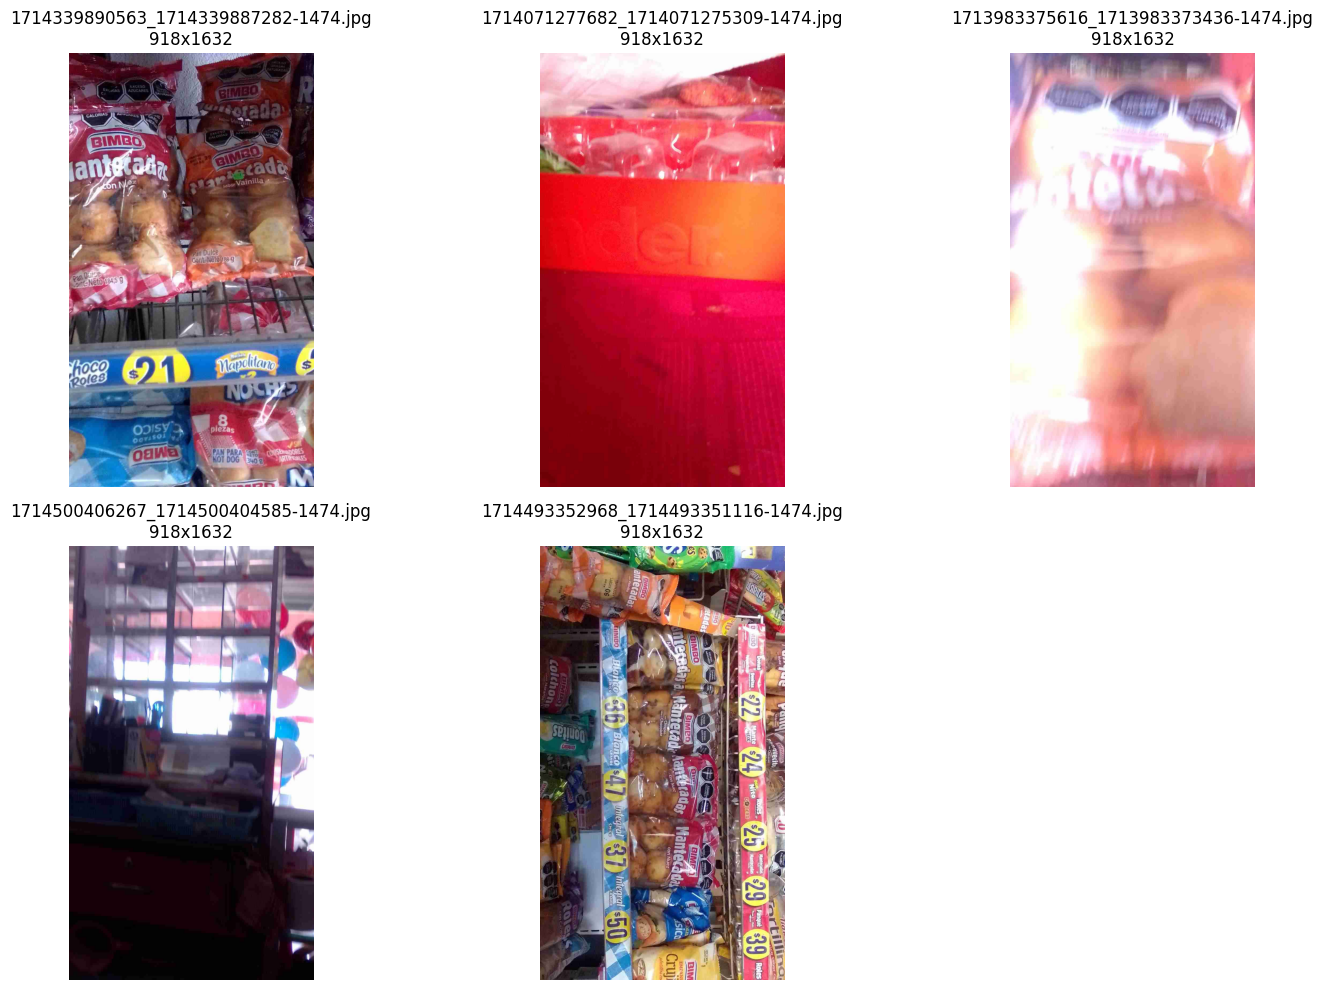


Analizando propiedades de las imágenes...
Procesando imagen 100/3478...
Procesando imagen 200/3478...
Procesando imagen 300/3478...
Procesando imagen 400/3478...
Procesando imagen 500/3478...
Procesando imagen 600/3478...
Procesando imagen 700/3478...
Procesando imagen 800/3478...
Procesando imagen 900/3478...
Procesando imagen 1000/3478...
Procesando imagen 1100/3478...
Procesando imagen 1200/3478...
Procesando imagen 1300/3478...
Procesando imagen 1400/3478...
Procesando imagen 1500/3478...
Procesando imagen 1600/3478...
Procesando imagen 1700/3478...
Procesando imagen 1800/3478...
Procesando imagen 1900/3478...
Procesando imagen 2000/3478...
Procesando imagen 2100/3478...
Procesando imagen 2200/3478...
Procesando imagen 2300/3478...
Procesando imagen 2400/3478...
Procesando imagen 2500/3478...
Procesando imagen 2600/3478...
Procesando imagen 2700/3478...
Procesando imagen 2800/3478...
Procesando imagen 2900/3478...
Procesando imagen 3000/3478...
Procesando imagen 3100/3478...
Proce

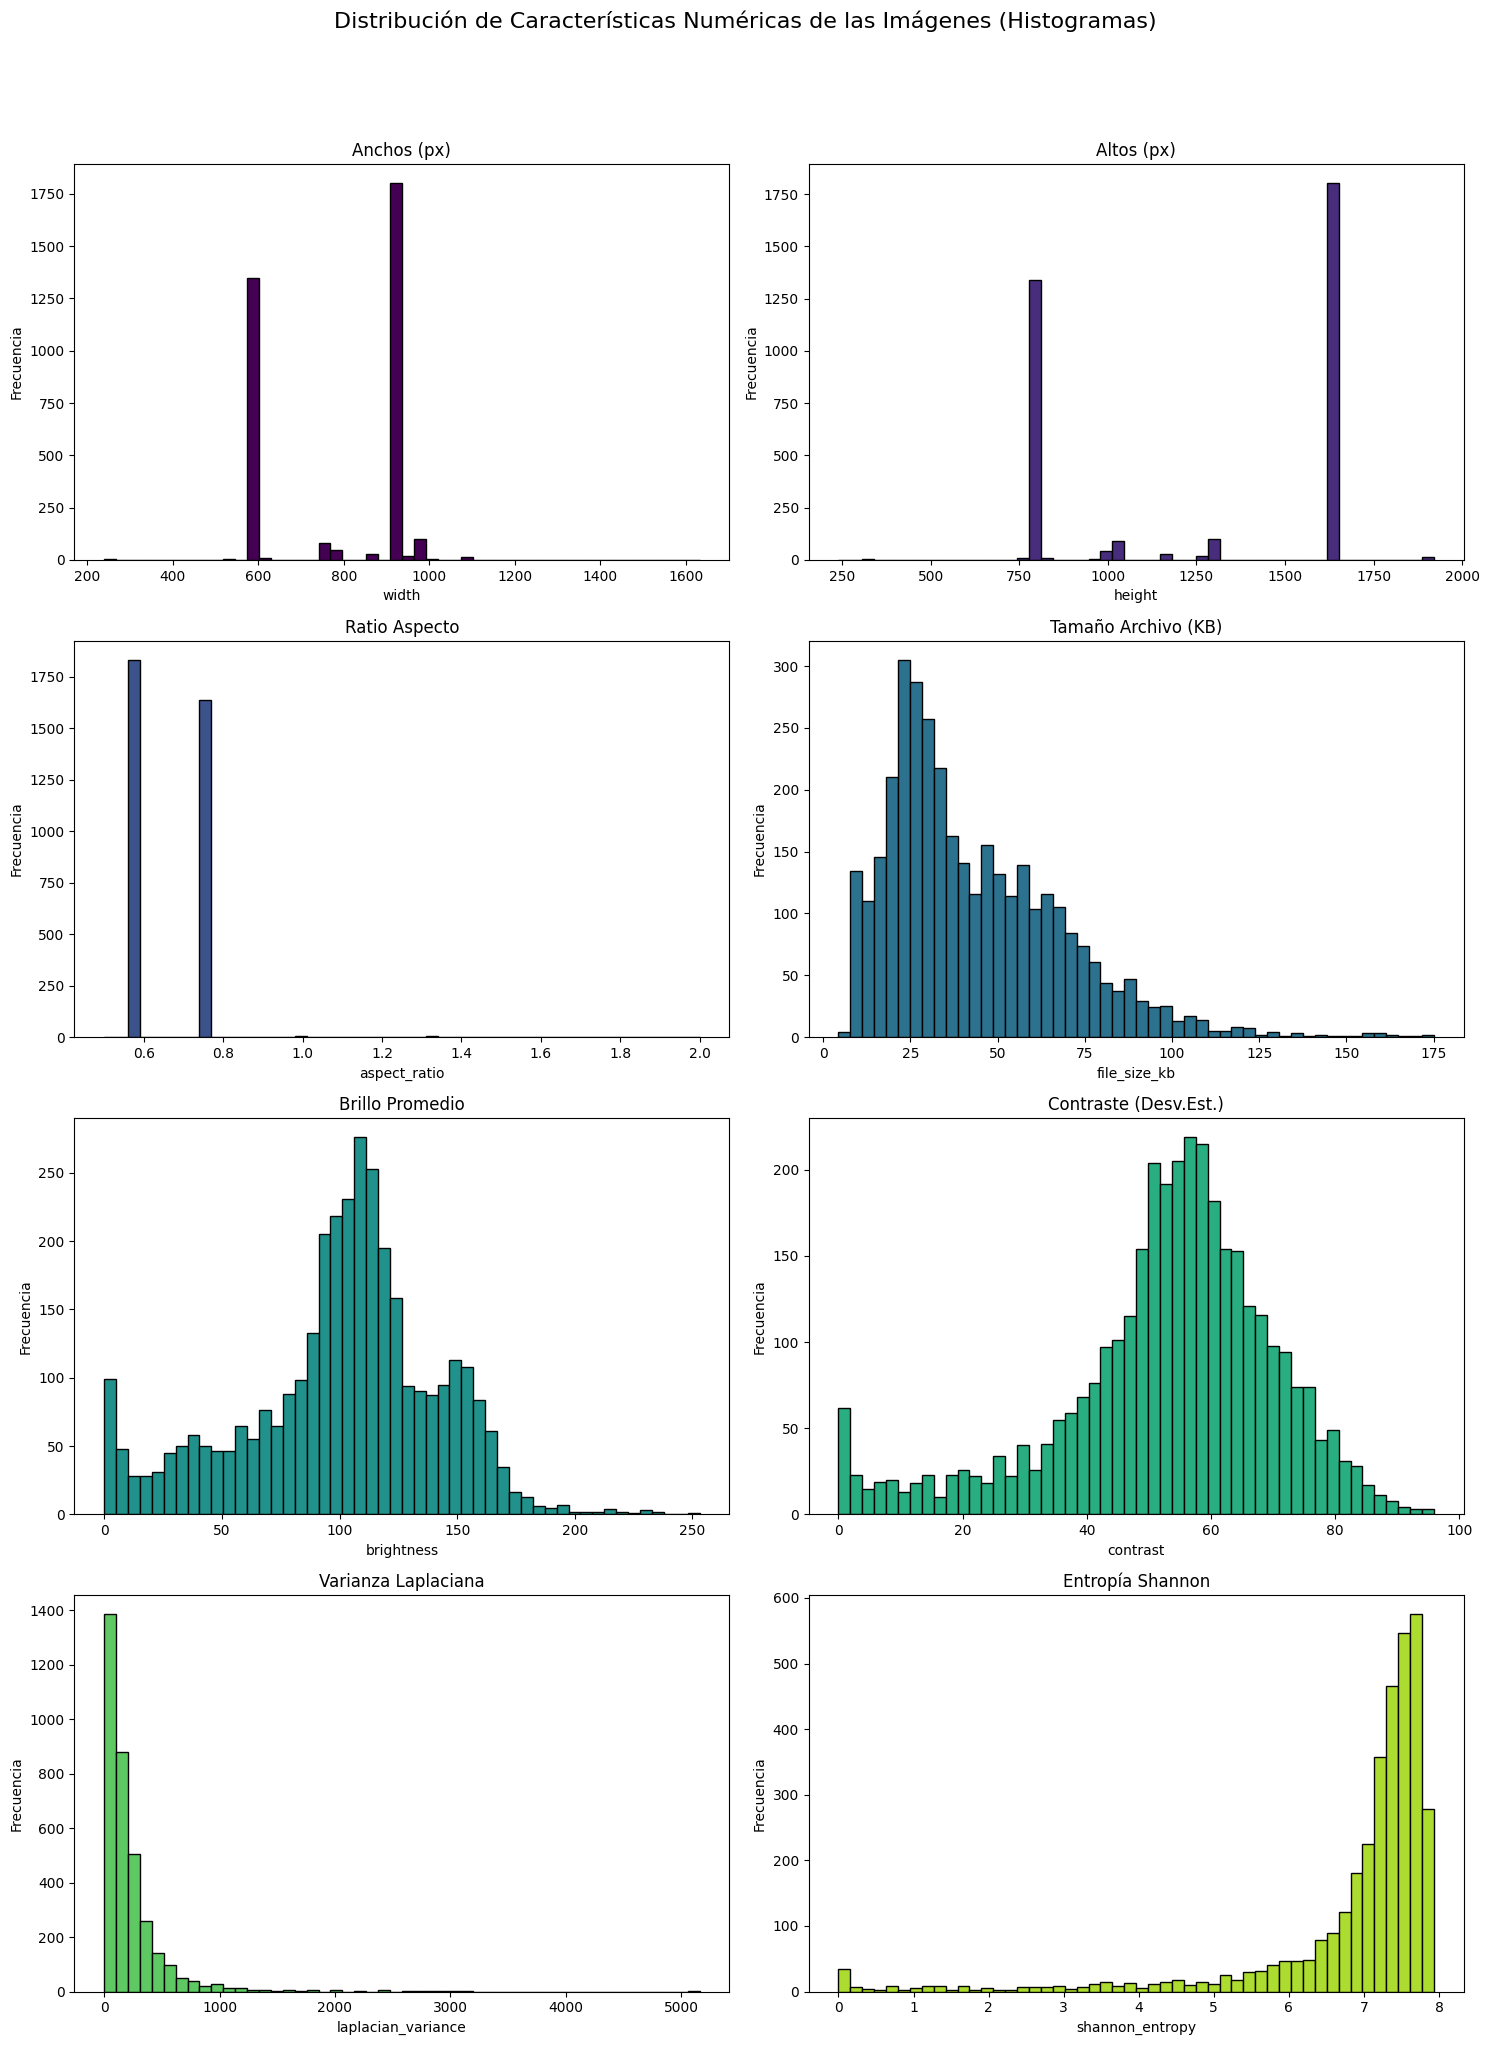


--- Conteo de Canales de Color (Pillow) ---
channels
3    3478
Name: count, dtype: int64

--- Conteo de Modos de Imagen (Pillow) ---
mode
RGB    3478
Name: count, dtype: int64

Generando Análisis Avanzados (Box Plots, Correlaciones, Pares)...

--- Generando Box Plots para Métricas Numéricas (Identificación de Atípicos) ---


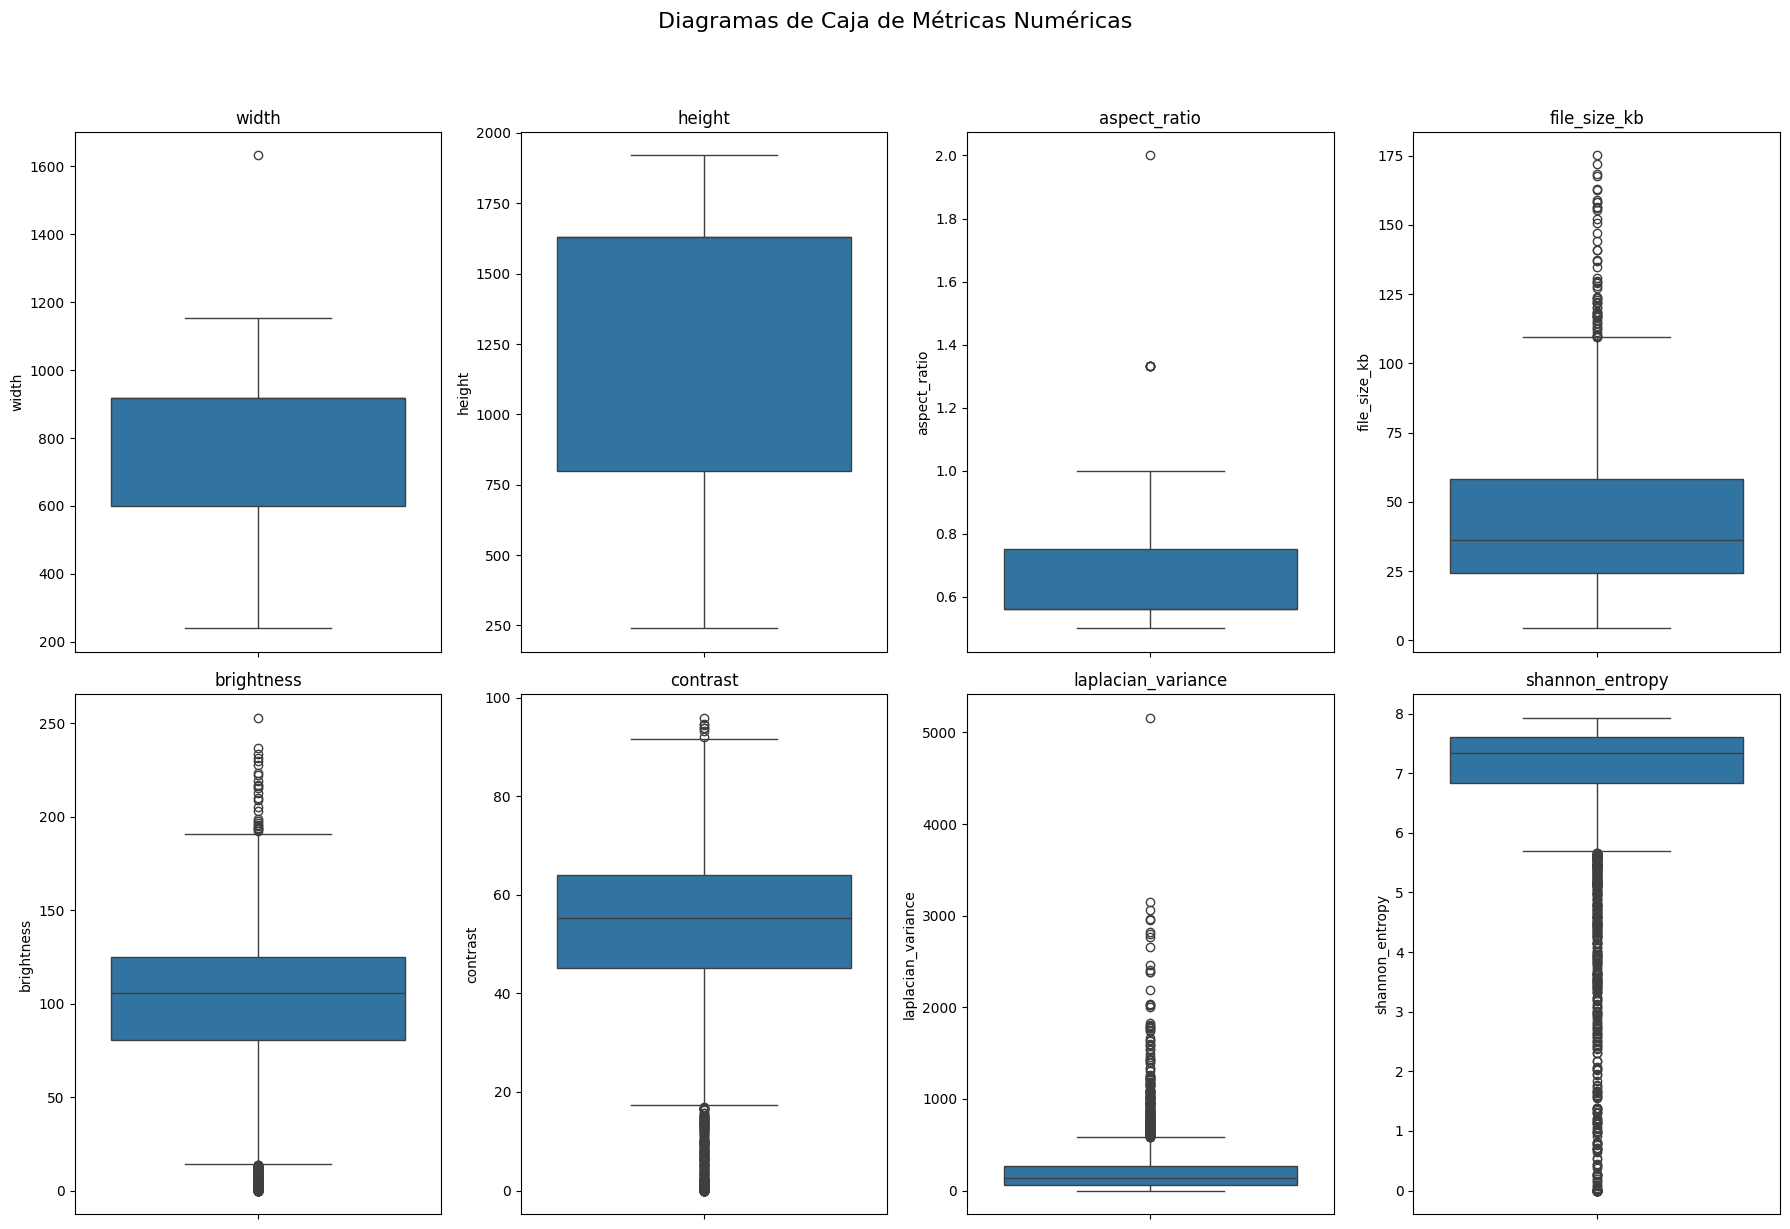


--- Generando Matriz de Correlación y Mapa de Calor ---


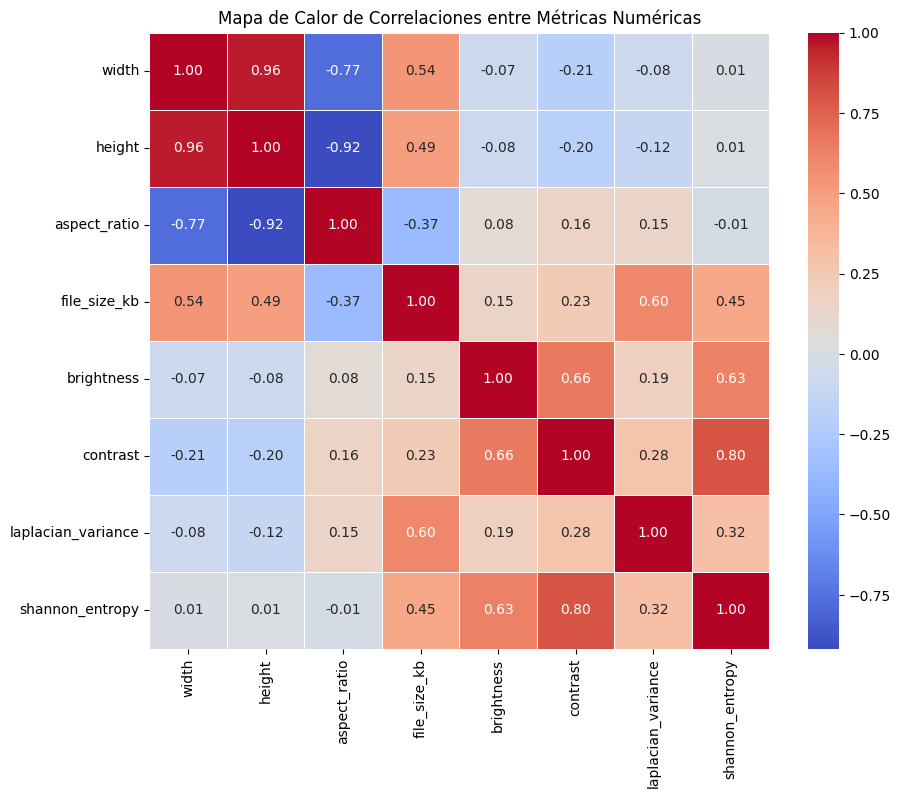

Interpretación del Mapa de Calor:
 - Valores cercanos a 1 o -1 indican una fuerte correlación lineal positiva o negativa, respectivamente.
 - Valores cercanos a 0 indican poca o ninguna correlación lineal.

--- Generando Pair Plot para Métricas Clave (Análisis Bivariado) ---


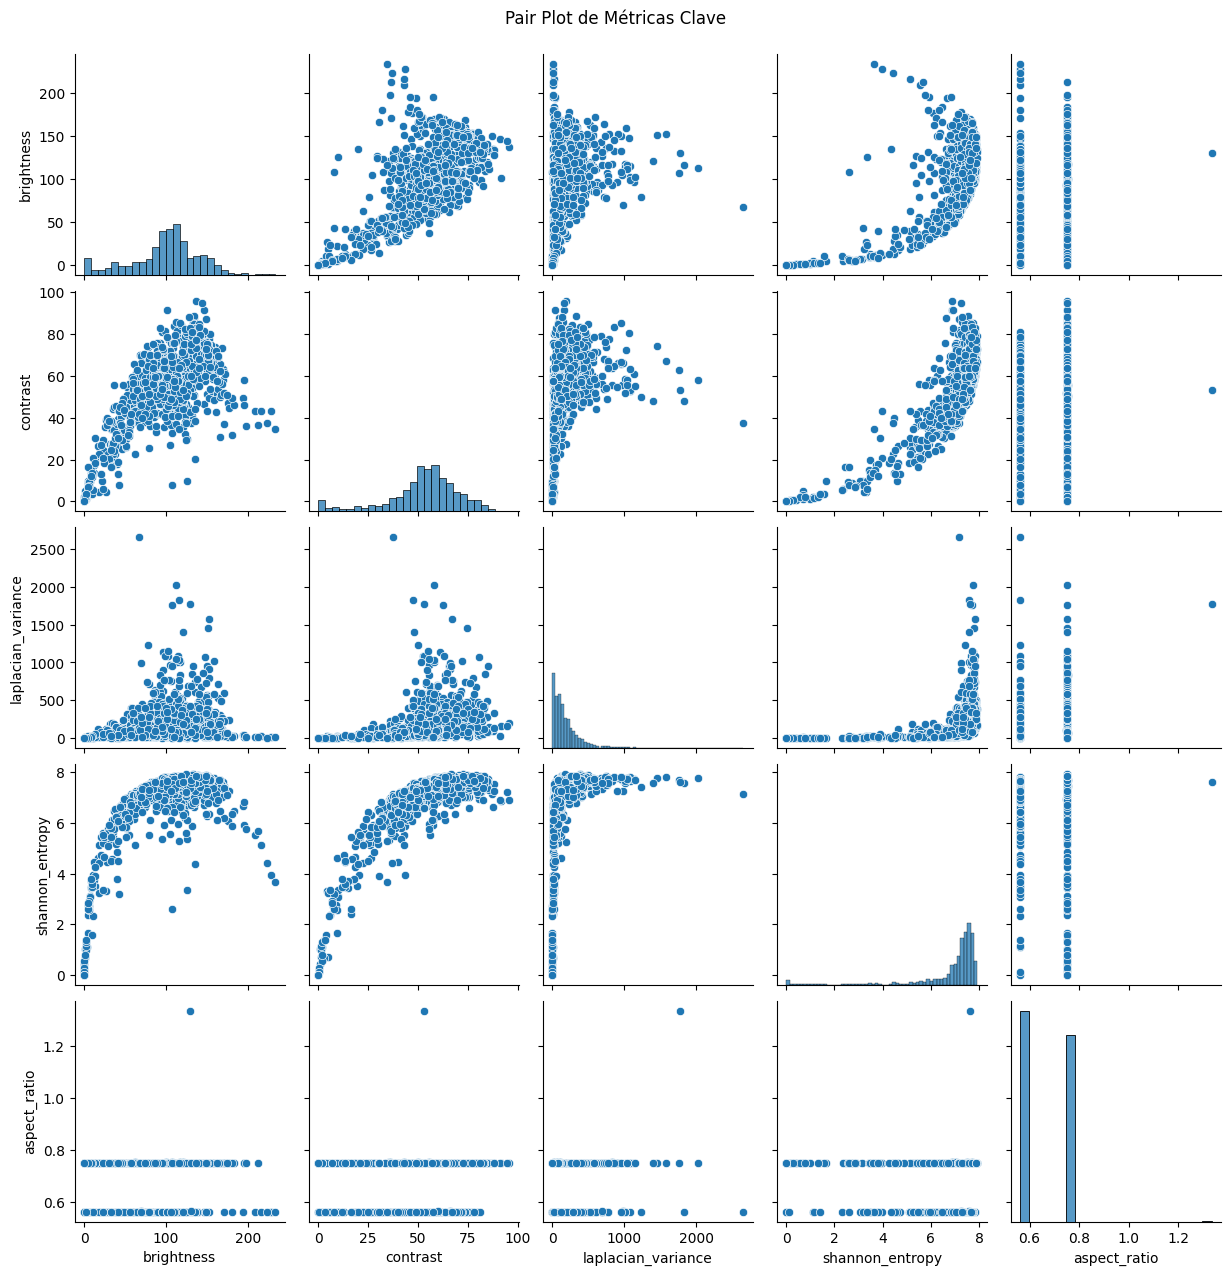


--- Generando Box Plots Agrupados (Ejemplos) ---


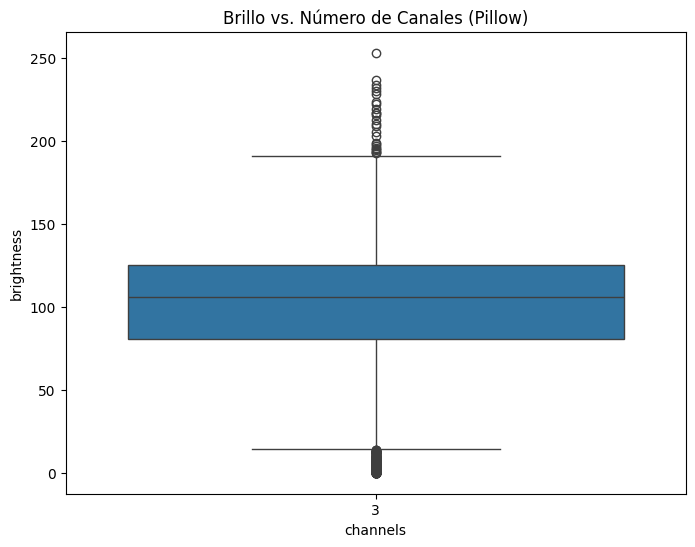

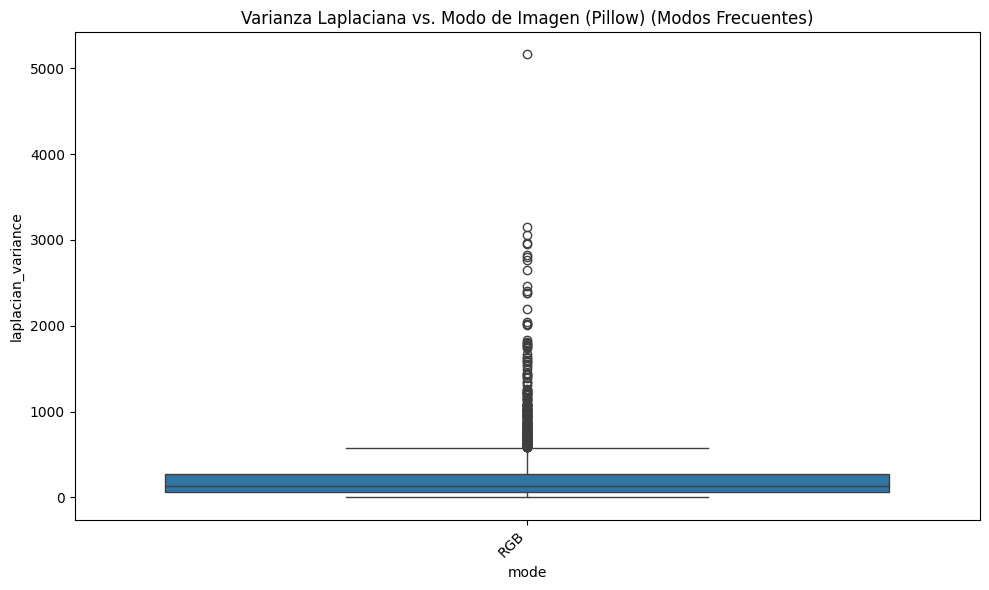

ADVERTENCIA: Dir 'output_image_analysis_bimbo' existe y contiene archivos.

Guardando imágenes categorizadas...
  Imágenes en 'good': 1935
  Imágenes en 'blurred': 1345
  Imágenes en 'dark': 716
  Imágenes en 'bright': 33
  Imágenes en 'low_entropy': 193
  Imágenes en 'other_issues': 0
Directorio de salida: C:\Users\bo244\MNA\Bimbonet\output_image_analysis_bimbo

--- Conclusiones del EDA (Ejemplos basados en hallazgos típicos) ---
1. Valores Faltantes: Revisar el conteo de NaNs. Si una métrica tiene muchos NaNs, investigar por qué (ej. problemas de lectura de imagen para OpenCV).
2. Estadísticas y Distribuciones: Observar medias, medianas y desviaciones. Histogramas y Box Plots revelan la forma de las distribuciones (ej. sesgo en 'file_size_kb' o 'brightness') y la presencia de valores atípicos.
   - Atípicos: Los box plots los señalan directamente. Las carpetas de imágenes categorizadas (oscuras, borrosas) también contienen atípicos definidos por umbrales.
3. Cardinalidad: Los conteos

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, UnidentifiedImageError
from glob import glob
from skimage.measure import shannon_entropy
import random
import shutil
import seaborn as sns # Importado para gráficos avanzados

# --- Configuración ---
# !!! MODIFICA ESTA RUTA A LA CARPETA DONDE TIENES TUS IMÁGENES !!!
IMAGE_DIR = 'Complete_Bimbo/Fotos Chambita 1364''
# Directorio base donde se guardarán las carpetas con imágenes categorizadas
OUTPUT_ANALYSIS_DIR = 'output_image_analysis_bimbo'

NUM_IMAGES_TO_PROCESS = None 
SAMPLE_IMAGES_TO_SHOW = 5

BLUR_THRESHOLD_LAPLACIAN = 100.0
DARK_THRESHOLD_BRIGHTNESS = 70.0
BRIGHT_THRESHOLD_BRIGHTNESS = 185.0
LOW_ENTROPY_THRESHOLD = 4.0 

# --- Funciones Auxiliares (mayormente sin cambios) ---
def get_image_paths(image_dir):
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif']
    image_paths = []
    for ext in extensions:
        image_paths.extend(glob(os.path.join(image_dir, ext)))
    print(f"Se encontraron {len(image_paths)} imágenes en '{image_dir}'.")
    if not image_paths:
        print("ADVERTENCIA: No se encontraron imágenes. Verifica la ruta y las extensiones.")
    return image_paths

def display_sample_images(image_paths, n_samples=5):
    if not image_paths:
        print("No hay imágenes para mostrar.")
        return
    actual_samples = min(n_samples, len(image_paths))
    if actual_samples == 0:
        print("No hay imágenes para mostrar.")
        return
    sample_paths = random.sample(image_paths, actual_samples)
    cols = 3
    rows = (actual_samples + cols - 1) // cols
    plt.figure(figsize=(15, 5 * rows))
    for i, img_path in enumerate(sample_paths):
        try:
            img = Image.open(img_path)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.title(f"{os.path.basename(img_path)}\n{img.size[0]}x{img.size[1]}")
            plt.axis('off')
        except UnidentifiedImageError:
            print(f"No se pudo abrir la imagen: {img_path}")
        except Exception as e:
            print(f"Error al mostrar la imagen {img_path}: {e}")
    plt.tight_layout()
    plt.show()

def calculate_brightness(image_cv):
    if image_cv is None: return None
    if len(image_cv.shape) == 3 and image_cv.shape[2] == 3: 
        gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
    elif len(image_cv.shape) == 2: 
        gray = image_cv
    else: 
        try: gray = cv2.cvtColor(image_cv, cv2.COLOR_BGRA2GRAY) 
        except cv2.error: return None
    return np.mean(gray)

def calculate_contrast(image_cv):
    if image_cv is None: return None
    if len(image_cv.shape) == 3 and image_cv.shape[2] == 3: gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
    elif len(image_cv.shape) == 2: gray = image_cv
    else:
        try: gray = cv2.cvtColor(image_cv, cv2.COLOR_BGRA2GRAY)
        except cv2.error: return None
    return np.std(gray)

def calculate_laplacian_variance(image_cv):
    if image_cv is None: return None
    if len(image_cv.shape) == 3 and image_cv.shape[2] == 3: gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
    elif len(image_cv.shape) == 2: gray = image_cv
    else:
        try: gray = cv2.cvtColor(image_cv, cv2.COLOR_BGRA2GRAY)
        except cv2.error: return None
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def calculate_shannon_entropy(image_cv):
    if image_cv is None: return None
    if len(image_cv.shape) == 3 and image_cv.shape[2] == 3: gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
    elif len(image_cv.shape) == 2: gray = image_cv
    else:
        try: gray = cv2.cvtColor(image_cv, cv2.COLOR_BGRA2GRAY)
        except cv2.error: return None
    return shannon_entropy(gray)

def analyze_images(image_paths, num_to_process=None):
    data = []
    paths_to_analyze = image_paths
    if num_to_process and num_to_process < len(image_paths):
        paths_to_analyze = random.sample(image_paths, num_to_process)
        print(f"Analizando una muestra de {num_to_process} imágenes.")
    processed_count = 0; error_count = 0
    for i, img_path in enumerate(paths_to_analyze):
        if (i + 1) % 100 == 0: print(f"Procesando imagen {i+1}/{len(paths_to_analyze)}...")
        try:
            with Image.open(img_path) as img_pil:
                width, height = img_pil.size
                mode = img_pil.mode 
                channels = len(img_pil.getbands())
            img_cv = cv2.imread(img_path, cv2.IMREAD_UNCHANGED) 
            if img_cv is None: 
                brightness, contrast, lap_var, entropy = None, None, None, None
            else:
                brightness = calculate_brightness(img_cv)
                contrast = calculate_contrast(img_cv)
                lap_var = calculate_laplacian_variance(img_cv)
                entropy = calculate_shannon_entropy(img_cv)
            file_size_kb = os.path.getsize(img_path) / 1024
            aspect_ratio = width / height if height > 0 else 0
            data.append({'filename': os.path.basename(img_path), 'path': img_path, 'width': width, 'height': height,
                         'channels': channels, 'mode': mode, 'aspect_ratio': aspect_ratio, 'file_size_kb': file_size_kb,
                         'brightness': brightness, 'contrast': contrast, 'laplacian_variance': lap_var, 'shannon_entropy': entropy})
            processed_count += 1
        except Exception as e: error_count += 1; print(f"ERROR procesando {img_path}: {e}")
    print(f"Análisis completado. Procesadas: {processed_count}. Errores: {error_count}.")
    return pd.DataFrame(data) if data else None

def plot_distributions(df):
    if df is None or df.empty: print("No hay datos para graficar distribuciones."); return
    df_clean = df.dropna(subset=['width', 'height', 'aspect_ratio', 'file_size_kb',
                                 'brightness', 'contrast', 'laplacian_variance', 'shannon_entropy'])
    if df_clean.empty: print("No hay datos válidos para graficar distribuciones tras eliminar NaNs."); return
    
    numerical_cols = ['width', 'height', 'aspect_ratio', 'file_size_kb', 
                      'brightness', 'contrast', 'laplacian_variance', 'shannon_entropy']
    titles = ['Anchos (px)', 'Altos (px)', 'Ratio Aspecto', 'Tamaño Archivo (KB)',
              'Brillo Promedio', 'Contraste (Desv.Est.)', 'Varianza Laplaciana', 'Entropía Shannon']
    
    fig, axes = plt.subplots( (len(numerical_cols) + 1)//2 , 2, figsize=(15, 5 * ((len(numerical_cols)+1)//2) ))
    axes = axes.flatten() # Para fácil iteración
    fig.suptitle('Distribución de Características Numéricas de las Imágenes (Histogramas)', fontsize=16, y=1.02)
    for i, col in enumerate(numerical_cols):
        if col in df_clean:
            axes[i].hist(df_clean[col], bins=50, color=plt.cm.viridis(i/len(numerical_cols)), edgecolor='black')
            axes[i].set_title(titles[i])
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frecuencia')
    # Ocultar ejes no usados si el número de plots es impar
    if len(numerical_cols) % 2 != 0:
        axes[-1].set_visible(False)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    print("\n--- Conteo de Canales de Color (Pillow) ---")
    if 'channels' in df: print(df['channels'].value_counts())
    print("\n--- Conteo de Modos de Imagen (Pillow) ---")
    if 'mode' in df: print(df['mode'].value_counts())

def print_summary_statistics(df):
    if df is None or df.empty: print("No hay datos para estadísticas descriptivas."); return
    print("\n--- Estadísticas Descriptivas de Métricas Numéricas ---")
    numerical_cols = ['width', 'height', 'aspect_ratio', 'file_size_kb', 
                      'brightness', 'contrast', 'laplacian_variance', 'shannon_entropy']
    existing_numerical_cols = [col for col in numerical_cols if col in df.columns]
    if existing_numerical_cols:
        print(df[existing_numerical_cols].describe())
    else:
        print("No se encontraron columnas numéricas estándar para describir.")
    
    print("\n--- Conteo de Valores Faltantes (NaN) por Métrica Calculada ---")
    nan_counts = df[existing_numerical_cols].isnull().sum()
    nan_counts = nan_counts[nan_counts > 0] # Mostrar solo columnas con NaNs
    if not nan_counts.empty:
        print(nan_counts)
    else:
        print("No se encontraron valores faltantes en las métricas numéricas principales.")

# --- NUEVAS FUNCIONES PARA ANÁLISIS AVANZADO ---
def plot_advanced_analysis(df):
    if df is None or df.empty: print("No hay datos para análisis avanzado."); return

    numerical_cols = ['width', 'height', 'aspect_ratio', 'file_size_kb', 
                      'brightness', 'contrast', 'laplacian_variance', 'shannon_entropy']
    df_numeric = df[numerical_cols].copy().dropna() # Usar copia y quitar NaNs para estos plots

    if df_numeric.empty: print("No hay suficientes datos numéricos válidos para análisis avanzado."); return

    # 1. Box Plots para cada métrica numérica
    print("\n--- Generando Box Plots para Métricas Numéricas (Identificación de Atípicos) ---")
    plt.figure(figsize=(18, 12))
    plt.suptitle('Diagramas de Caja de Métricas Numéricas', fontsize=16, y=1.02)
    for i, col in enumerate(df_numeric.columns):
        plt.subplot(2, 4, i + 1) # Asumiendo 8 métricas, ajustar si cambia
        sns.boxplot(y=df_numeric[col])
        plt.title(col)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    # 2. Matriz de Correlación y Heatmap
    print("\n--- Generando Matriz de Correlación y Mapa de Calor ---")
    correlation_matrix = df_numeric.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Mapa de Calor de Correlaciones entre Métricas Numéricas')
    plt.show()
    print("Interpretación del Mapa de Calor:")
    print(" - Valores cercanos a 1 o -1 indican una fuerte correlación lineal positiva o negativa, respectivamente.")
    print(" - Valores cercanos a 0 indican poca o ninguna correlación lineal.")

    # 3. Pair Plot para un subconjunto de métricas clave
    print("\n--- Generando Pair Plot para Métricas Clave (Análisis Bivariado) ---")
    key_metrics_for_pairplot = ['brightness', 'contrast', 'laplacian_variance', 'shannon_entropy', 'aspect_ratio']
    # Filtrar para asegurar que las columnas existen y hay datos
    key_metrics_present = [m for m in key_metrics_for_pairplot if m in df_numeric.columns and df_numeric[m].nunique() > 1]

    if len(key_metrics_present) >= 2: # Pairplot necesita al menos 2 variables
        pair_plot_data = df_numeric[key_metrics_present]
        # Limitar el número de muestras para el pairplot si el dataset es muy grande para evitar lentitud
        sample_size_pairplot = min(1000, len(pair_plot_data))
        sns.pairplot(pair_plot_data.sample(sample_size_pairplot, random_state=1) if len(pair_plot_data) > sample_size_pairplot else pair_plot_data)
        plt.suptitle('Pair Plot de Métricas Clave', y=1.02)
        plt.show()
    else:
        print("No hay suficientes métricas clave con datos variados para generar el Pair Plot.")

    # 4. Box Plots Agrupados (ej. brillo por número de canales)
    print("\n--- Generando Box Plots Agrupados (Ejemplos) ---")
    if 'channels' in df.columns and 'brightness' in df_numeric.columns:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='channels', y='brightness', data=df.dropna(subset=['channels', 'brightness']))
        plt.title('Brillo vs. Número de Canales (Pillow)')
        plt.show()

    if 'mode' in df.columns and 'laplacian_variance' in df_numeric.columns:
        # Solo tomar modos con suficientes muestras para que el boxplot sea informativo
        valid_modes = df['mode'].value_counts()
        valid_modes = valid_modes[valid_modes > 10].index # Modos con más de 10 muestras
        df_filtered_modes = df[df['mode'].isin(valid_modes)]

        if not df_filtered_modes.empty:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x='mode', y='laplacian_variance', data=df_filtered_modes.dropna(subset=['mode', 'laplacian_variance']))
            plt.title('Varianza Laplaciana vs. Modo de Imagen (Pillow) (Modos Frecuentes)')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print("No hay suficientes datos o modos frecuentes para el boxplot de Varianza Laplaciana vs Modo.")


# --- Funciones para Guardar Imágenes Categorizadas (sin cambios) ---
def create_output_folders(base_dir):
    folders = {'good': os.path.join(base_dir, 'potentially_good_images'),
               'blurred': os.path.join(base_dir, 'potentially_blurred_images'),
               'dark': os.path.join(base_dir, 'potentially_dark_images'),
               'bright': os.path.join(base_dir, 'potentially_bright_images'),
               'low_entropy': os.path.join(base_dir, 'potentially_low_entropy_images'),
               'other_issues': os.path.join(base_dir, 'other_potential_issues')}
    if not os.path.exists(base_dir): os.makedirs(base_dir); print(f"Dir base creado: {base_dir}")
    elif os.listdir(base_dir): print(f"ADVERTENCIA: Dir '{base_dir}' existe y contiene archivos.")
    for fp in folders.values(): os.makedirs(fp, exist_ok=True)
    return folders

def save_categorized_images(df, output_folders):
    if df is None or df.empty: print("No hay datos para categorizar/guardar."); return
    print("\nGuardando imágenes categorizadas...")
    counts = {key: 0 for key in output_folders.keys()}
    for _, row in df.iterrows():
        src_path = row['path']; filename = row['filename']
        if not os.path.exists(src_path): print(f"ADVERTENCIA: Origen no existe: {src_path}"); continue
        
        copied_to_problem_folder = False
        if pd.isna(row['laplacian_variance']) or pd.isna(row['brightness']) or pd.isna(row['shannon_entropy']):
            try: shutil.copy2(src_path, os.path.join(output_folders['other_issues'], filename)); counts['other_issues']+=1; copied_to_problem_folder=True
            except Exception as e: print(f"Error copia N/A {filename}: {e}")
        
        if not pd.isna(row['laplacian_variance']) and row['laplacian_variance'] < BLUR_THRESHOLD_LAPLACIAN:
            try: shutil.copy2(src_path, os.path.join(output_folders['blurred'], filename)); counts['blurred']+=1; copied_to_problem_folder=True
            except Exception as e: print(f"Error copia borrosa {filename}: {e}")
        
        if not pd.isna(row['brightness']):
            if row['brightness'] < DARK_THRESHOLD_BRIGHTNESS:
                try: shutil.copy2(src_path, os.path.join(output_folders['dark'], filename)); counts['dark']+=1; copied_to_problem_folder=True
                except Exception as e: print(f"Error copia oscura {filename}: {e}")
            elif row['brightness'] > BRIGHT_THRESHOLD_BRIGHTNESS:
                try: shutil.copy2(src_path, os.path.join(output_folders['bright'], filename)); counts['bright']+=1; copied_to_problem_folder=True
                except Exception as e: print(f"Error copia brillante {filename}: {e}")

        if not pd.isna(row['shannon_entropy']) and row['shannon_entropy'] < LOW_ENTROPY_THRESHOLD:
            try: shutil.copy2(src_path, os.path.join(output_folders['low_entropy'], filename)); counts['low_entropy']+=1; copied_to_problem_folder=True
            except Exception as e: print(f"Error copia baja entropía {filename}: {e}")

        if not copied_to_problem_folder:
            try: shutil.copy2(src_path, os.path.join(output_folders['good'], filename)); counts['good']+=1
            except Exception as e: print(f"Error copia buena {filename}: {e}")
            
    for cat, count in counts.items(): print(f"  Imágenes en '{cat}': {count}")
    print(f"Directorio de salida: {os.path.abspath(OUTPUT_ANALYSIS_DIR)}")

# --- Flujo Principal del EDA ---
if __name__ == '__main__':
    print("Iniciando Análisis Exploratorio de Datos de Imágenes...")
    current_datetime = pd.Timestamp.now()
    print(f"Fecha y hora de ejecución: {current_datetime.strftime('%Y-%m-%d %H:%M:%S')} (UTC{current_datetime.utcoffset()})")

    image_paths = get_image_paths(IMAGE_DIR)

    if image_paths:
        print(f"\nMostrando {SAMPLE_IMAGES_TO_SHOW} imágenes de muestra:")
        display_sample_images(image_paths, n_samples=SAMPLE_IMAGES_TO_SHOW)

        print("\nAnalizando propiedades de las imágenes...")
        image_data_df = analyze_images(image_paths, num_to_process=NUM_IMAGES_TO_PROCESS)

        if image_data_df is not None and not image_data_df.empty:
            if not os.path.exists(OUTPUT_ANALYSIS_DIR):
                 os.makedirs(OUTPUT_ANALYSIS_DIR, exist_ok=True)
            csv_output_path = os.path.join(OUTPUT_ANALYSIS_DIR, 'image_metadata_analysis.csv')
            try:
                image_data_df.to_csv(csv_output_path, index=False)
                print(f"\nMetadatos de imágenes guardados en: {csv_output_path}")
            except Exception as e:
                print(f"Error al guardar el CSV con metadatos: {e}")

            print_summary_statistics(image_data_df) # Ahora incluye conteo de NaNs
            
            print("\nGenerando gráficos de distribución (Histogramas)...")
            plot_distributions(image_data_df)

            print("\nGenerando Análisis Avanzados (Box Plots, Correlaciones, Pares)...")
            plot_advanced_analysis(image_data_df) # Nueva función llamada aquí

            output_folders_paths = create_output_folders(OUTPUT_ANALYSIS_DIR)
            save_categorized_images(image_data_df, output_folders_paths)

            print("\n--- Conclusiones del EDA (Ejemplos basados en hallazgos típicos) ---")
            print("1. Valores Faltantes: Revisar el conteo de NaNs. Si una métrica tiene muchos NaNs, investigar por qué (ej. problemas de lectura de imagen para OpenCV).")
            print("2. Estadísticas y Distribuciones: Observar medias, medianas y desviaciones. Histogramas y Box Plots revelan la forma de las distribuciones (ej. sesgo en 'file_size_kb' o 'brightness') y la presencia de valores atípicos.")
            print("   - Atípicos: Los box plots los señalan directamente. Las carpetas de imágenes categorizadas (oscuras, borrosas) también contienen atípicos definidos por umbrales.")
            print("3. Cardinalidad: Los conteos de 'channels' y 'mode' indican la variedad de formatos de imagen. Idealmente, se estandarizaría (ej. todas a RGB).")
            print("4. Sesgo y Transformaciones: Si una métrica como 'brillo' está muy sesgada, podría considerarse una transformación (ej. logarítmica) si esa métrica se usara directamente en un modelo que asume normalidad, o para mejorar visualizaciones.")
            print("5. Correlaciones: El mapa de calor muestra relaciones lineales. Por ejemplo, 'width' y 'height' suelen correlacionar con 'file_size_kb'. Una correlación fuerte entre 'brightness' y 'contrast' podría ser interesante.")
            print("6. Análisis Bivariado (Pair Plots, Box Plots Agrupados): Permiten ver cómo interactúan las variables. ¿Las imágenes RGB ('mode') tienen consistentemente mayor 'laplacian_variance' que las 'L' (escala de grises)?")
            print("   El Pair Plot puede revelar clusters o tendencias entre métricas de calidad.")
            
            print("\n--- Próximos Pasos Sugeridos (Adaptar a tus hallazgos específicos) ---")
            print(f"1. Revisar a fondo las imágenes guardadas en las subcarpetas de '{os.path.abspath(OUTPUT_ANALYSIS_DIR)}' y el CSV de metadatos.")
            print("2. Justificar Operaciones de Preprocesamiento:")
            print("   - Manejo de valores faltantes (en métricas): Decidir si imputar o si las imágenes asociadas son problemáticas y deben descartarse.")
            print("   - Atípicos: Decidir si los valores atípicos son errores o data válida extrema. Esto informa si se deben remover, transformar (capping/winsorizing) o si el modelo debe ser robusto a ellos.")
            print("   - Alta Cardinalidad (para 'mode'/'channels'): Ya está manejado al convertir a un formato estándar (ej. RGB) antes de alimentar a un modelo.")
            print("   - Reescalado/Normalización de imágenes: Basado en la variabilidad de dimensiones y las necesidades del modelo.")
            print("3. Si obtienes etiquetas de 'presencia/ausencia':")
            print("   - Realizar análisis de balance de clases.")
            print("   - Generar visualizaciones bivariadas de cada métrica vs. la etiqueta de clase (ej. box plots de 'brightness' para imágenes con y sin producto).")
            print("   - Investigar qué métricas se correlacionan más con la presencia del producto.")
            print("4. Si obtienes datos de tiempo de captura: Realizar análisis de tendencias temporales.")

        else:
            print("No se generaron datos para el análisis (DataFrame vacío o None).")
    else:
        print(f"No se encontraron imágenes en la ruta: {IMAGE_DIR}. Por favor, verifica la configuración.")

    print("\nFin del Análisis Exploratorio de Datos.")

Iniciando Análisis Exploratorio de Datos de Imágenes...
Fecha y hora de ejecución: 2025-05-18 18:08:54 (UTCNone)
Se encontraron 3478 imágenes en 'Complete_Bimbo/Fotos Chambita 1364'.

Mostrando 5 imágenes de muestra:


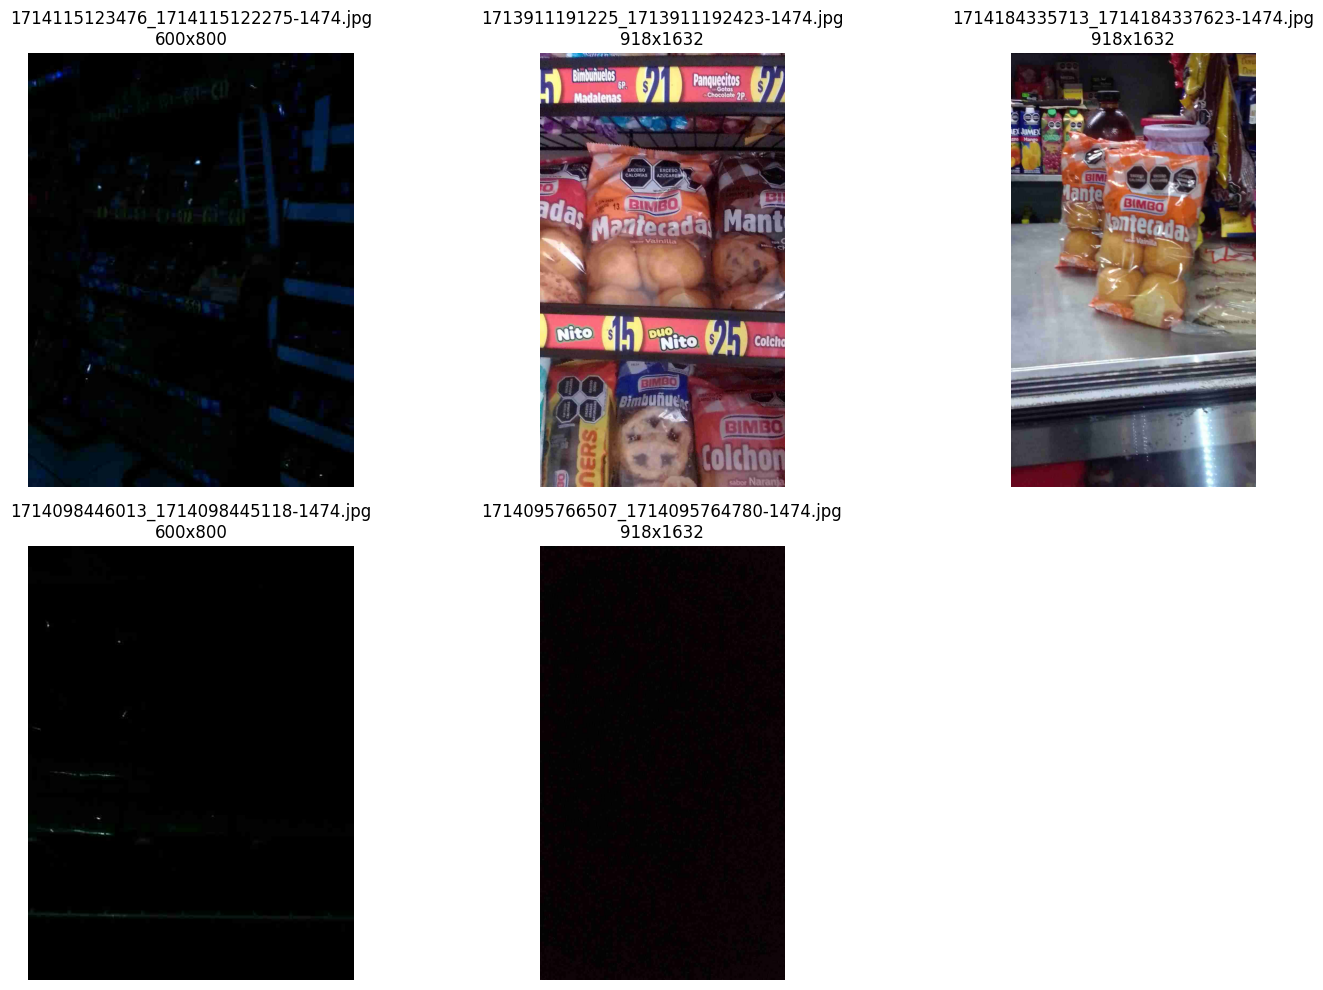


Analizando propiedades de las imágenes...
Procesando imagen 100/3478...
Procesando imagen 200/3478...
Procesando imagen 300/3478...
Procesando imagen 400/3478...
Procesando imagen 500/3478...
Procesando imagen 600/3478...
Procesando imagen 700/3478...
Procesando imagen 800/3478...
Procesando imagen 900/3478...
Procesando imagen 1000/3478...
Procesando imagen 1100/3478...
Procesando imagen 1200/3478...
Procesando imagen 1300/3478...
Procesando imagen 1400/3478...
Procesando imagen 1500/3478...
Procesando imagen 1600/3478...
Procesando imagen 1700/3478...
Procesando imagen 1800/3478...
Procesando imagen 1900/3478...
Procesando imagen 2000/3478...
Procesando imagen 2100/3478...
Procesando imagen 2200/3478...
Procesando imagen 2300/3478...
Procesando imagen 2400/3478...
Procesando imagen 2500/3478...
Procesando imagen 2600/3478...
Procesando imagen 2700/3478...
Procesando imagen 2800/3478...
Procesando imagen 2900/3478...
Procesando imagen 3000/3478...
Procesando imagen 3100/3478...
Proce

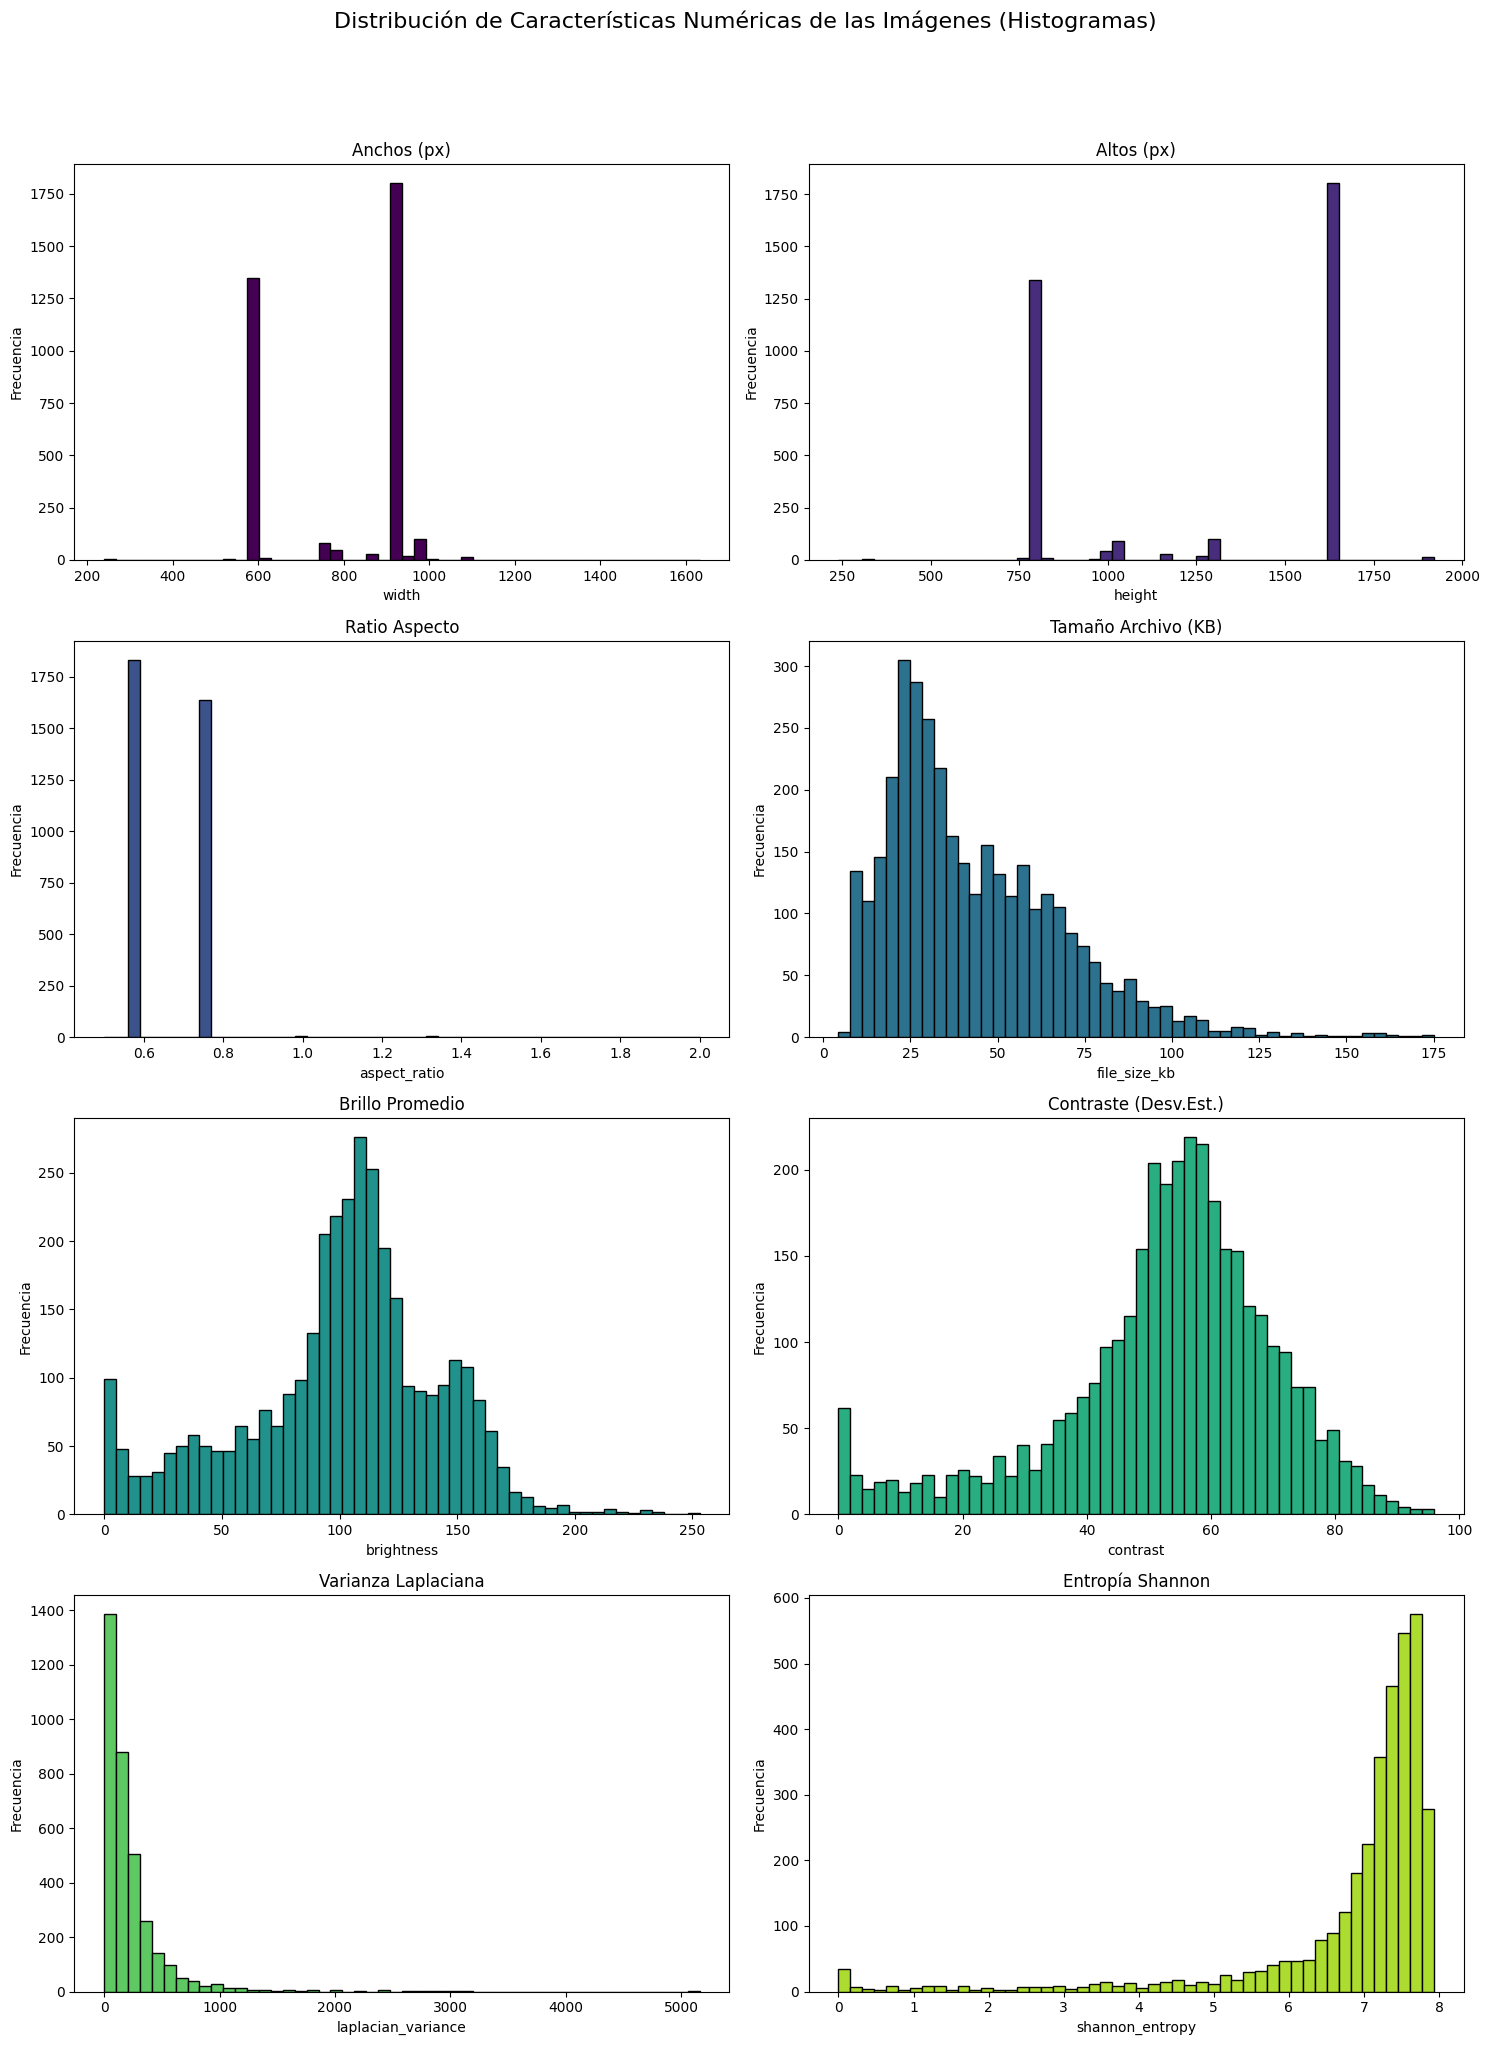


--- Conteo de Canales de Color (Pillow) ---
channels
3    3478
Name: count, dtype: int64

--- Conteo de Modos de Imagen (Pillow) ---
mode
RGB    3478
Name: count, dtype: int64

Generando Análisis Avanzados (Box Plots, Correlaciones, Pares)...

--- Generando Box Plots para Métricas Numéricas (Identificación de Atípicos) ---


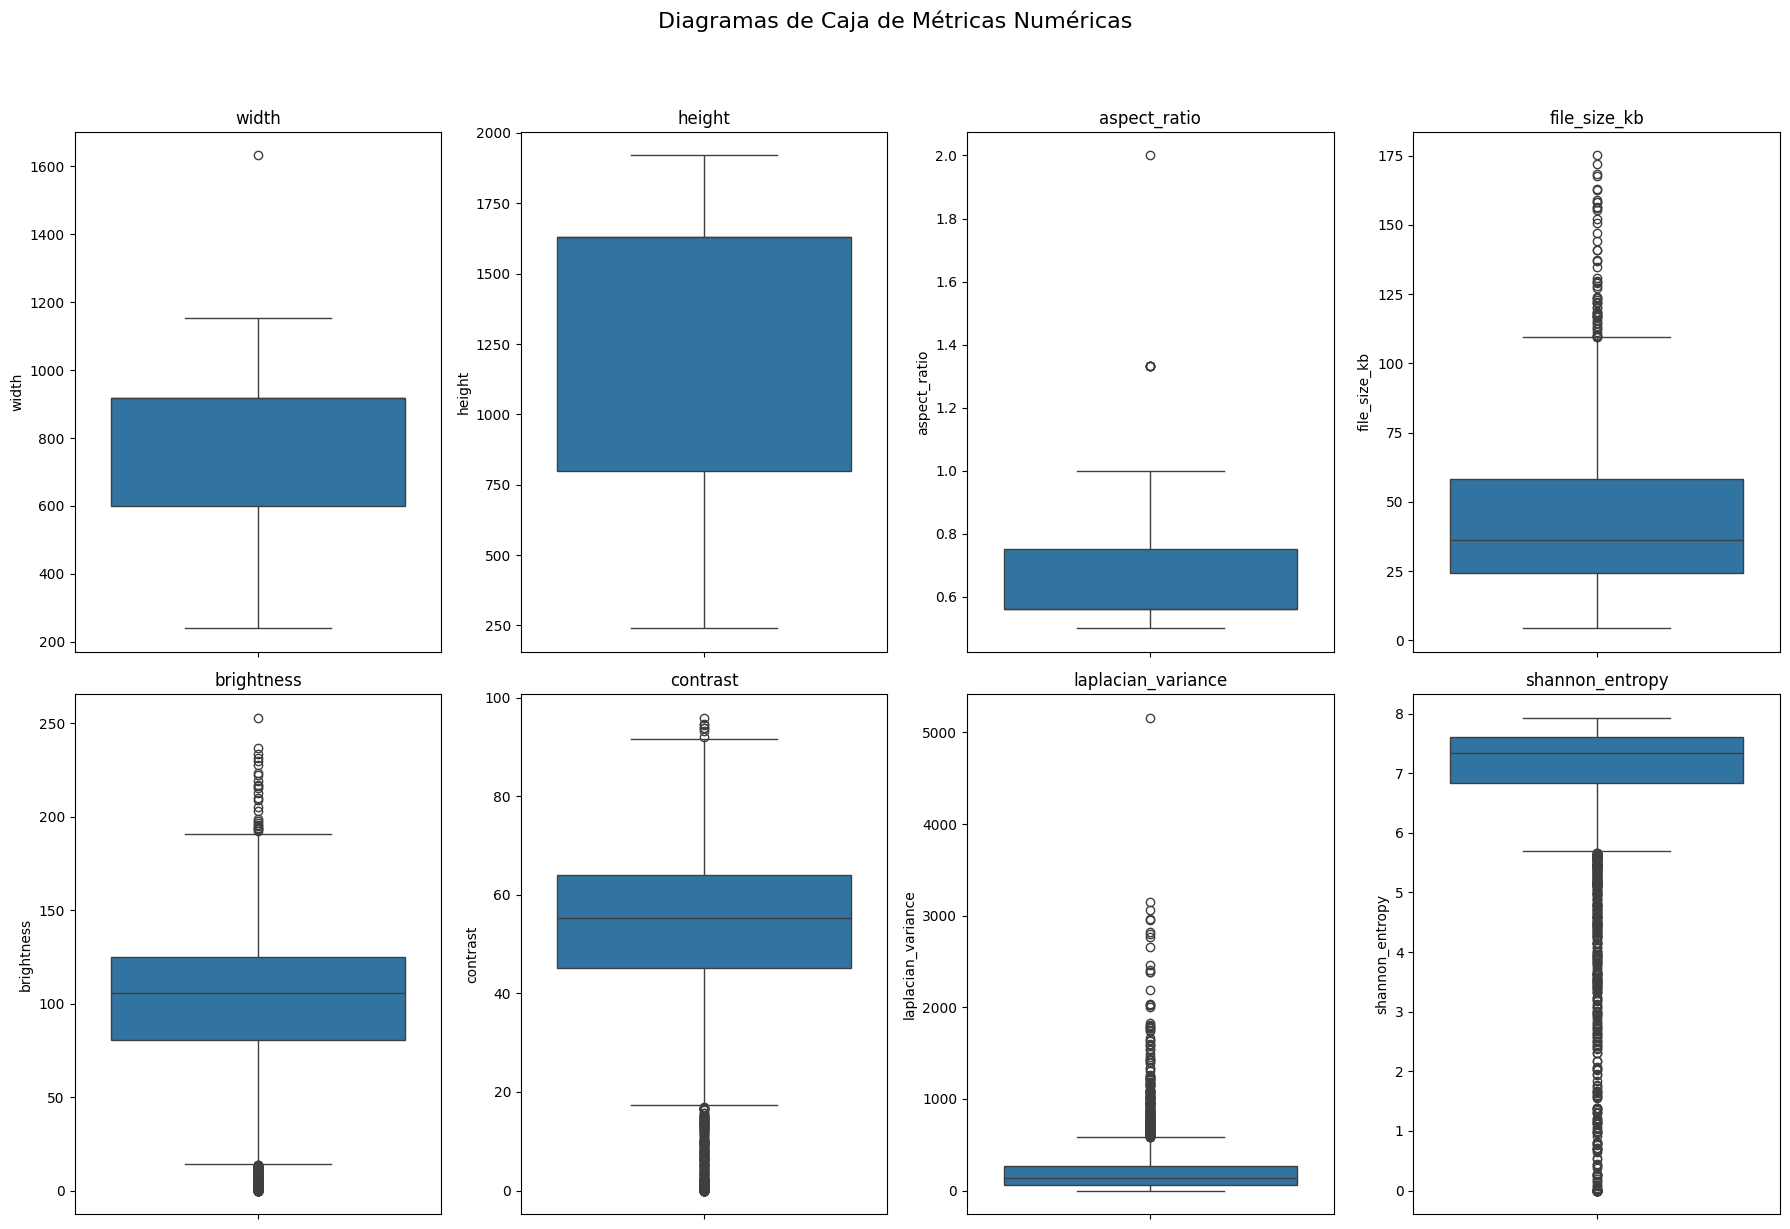


--- Generando Matriz de Correlación y Mapa de Calor ---


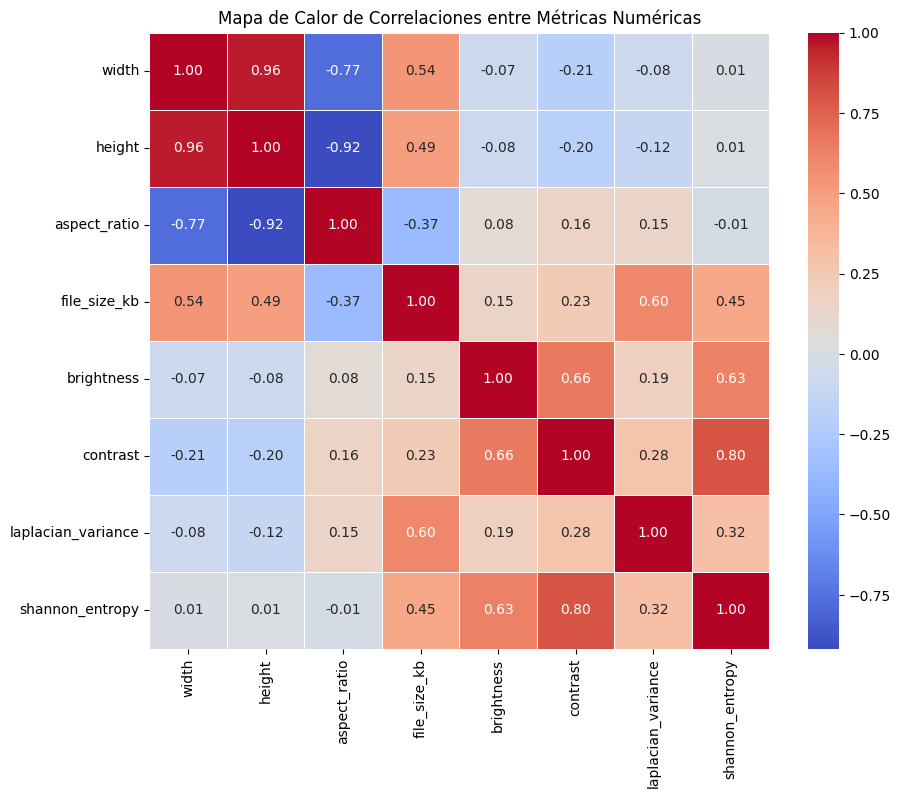

Interpretación del Mapa de Calor:
 - Valores cercanos a 1 o -1 indican una fuerte correlación lineal positiva o negativa, respectivamente.
 - Valores cercanos a 0 indican poca o ninguna correlación lineal.

--- Generando Pair Plot para Métricas Clave (Análisis Bivariado) ---


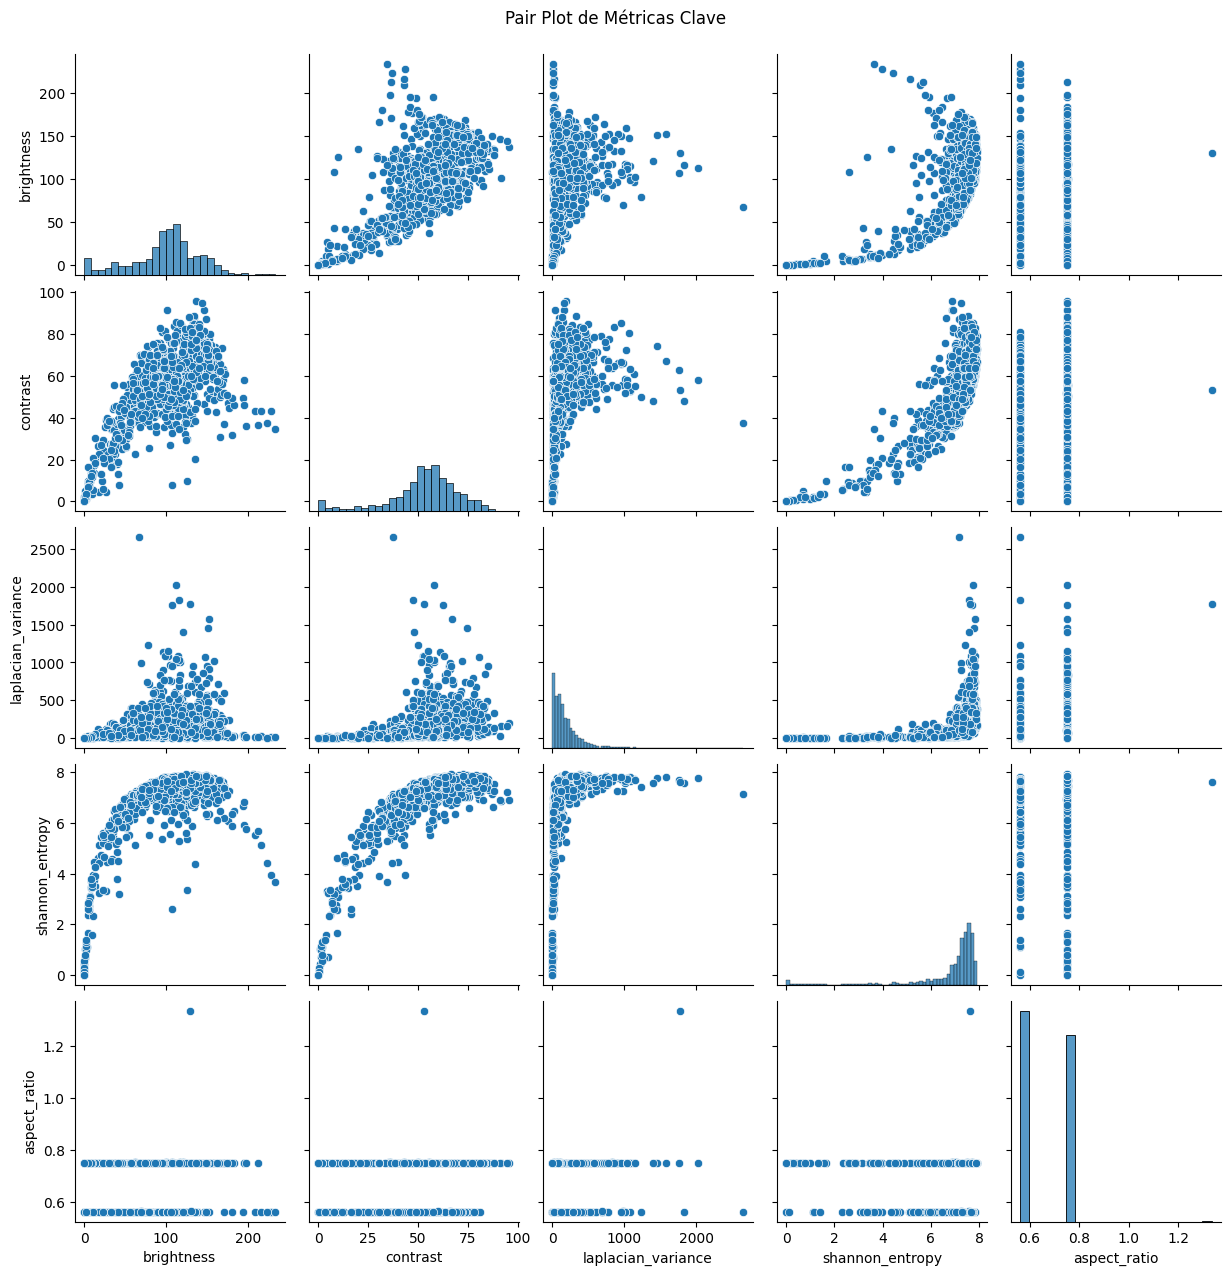


--- Generando Box Plots Agrupados (Ejemplos) ---


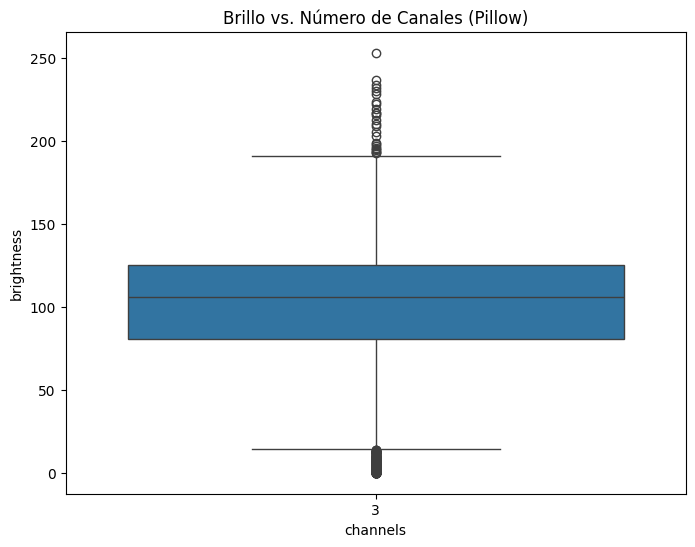

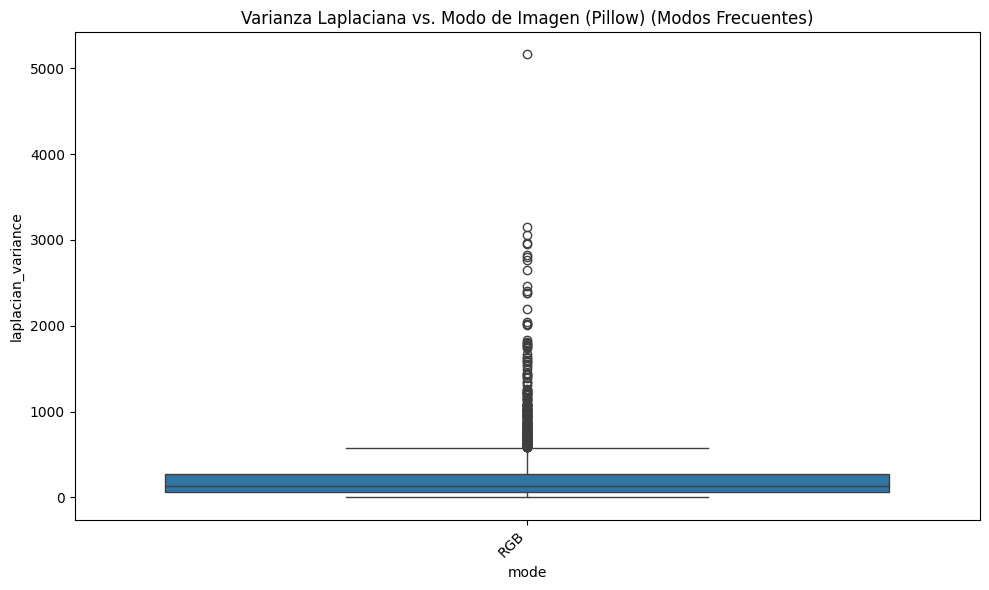

ADVERTENCIA: Dir 'output_image_analysis_bimbo' existe y contiene archivos.

Guardando imágenes categorizadas...
  Imágenes en 'good': 1935
  Imágenes en 'blurred': 1345
  Imágenes en 'dark': 716
  Imágenes en 'bright': 33
  Imágenes en 'low_entropy': 193
  Imágenes en 'other_issues': 0
Directorio de salida: C:\Users\bo244\MNA\Bimbonet\output_image_analysis_bimbo

--- Conclusiones del EDA (Ejemplos basados en hallazgos típicos) ---
1. Valores Faltantes: Revisar el conteo de NaNs. Si una métrica tiene muchos NaNs, investigar por qué (ej. problemas de lectura de imagen para OpenCV).
2. Estadísticas y Distribuciones: Observar medias, medianas y desviaciones. Histogramas y Box Plots revelan la forma de las distribuciones (ej. sesgo en 'file_size_kb' o 'brightness') y la presencia de valores atípicos.
   - Atípicos: Los box plots los señalan directamente. Las carpetas de imágenes categorizadas (oscuras, borrosas) también contienen atípicos definidos por umbrales.
3. Cardinalidad: Los conteos

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, UnidentifiedImageError
from glob import glob
from skimage.measure import shannon_entropy
import random
import shutil
import seaborn as sns # Importado para gráficos avanzados

# --- Configuración ---
# !!! MODIFICA ESTA RUTA A LA CARPETA DONDE TIENES TUS IMÁGENES !!!
IMAGE_DIR = 'Complete_Bimbo/Fotos Chambita 1364'
# Directorio base donde se guardarán las carpetas con imágenes categorizadas
OUTPUT_ANALYSIS_DIR = 'output_image_analysis_bimbo'

NUM_IMAGES_TO_PROCESS = None 
SAMPLE_IMAGES_TO_SHOW = 5

BLUR_THRESHOLD_LAPLACIAN = 100.0
DARK_THRESHOLD_BRIGHTNESS = 70.0
BRIGHT_THRESHOLD_BRIGHTNESS = 185.0
LOW_ENTROPY_THRESHOLD = 4.0 

# --- Funciones Auxiliares (mayormente sin cambios) ---
def get_image_paths(image_dir):
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif']
    image_paths = []
    for ext in extensions:
        image_paths.extend(glob(os.path.join(image_dir, ext)))
    print(f"Se encontraron {len(image_paths)} imágenes en '{image_dir}'.")
    if not image_paths:
        print("ADVERTENCIA: No se encontraron imágenes. Verifica la ruta y las extensiones.")
    return image_paths

def display_sample_images(image_paths, n_samples=5):
    if not image_paths:
        print("No hay imágenes para mostrar.")
        return
    actual_samples = min(n_samples, len(image_paths))
    if actual_samples == 0:
        print("No hay imágenes para mostrar.")
        return
    sample_paths = random.sample(image_paths, actual_samples)
    cols = 3
    rows = (actual_samples + cols - 1) // cols
    plt.figure(figsize=(15, 5 * rows))
    for i, img_path in enumerate(sample_paths):
        try:
            img = Image.open(img_path)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.title(f"{os.path.basename(img_path)}\n{img.size[0]}x{img.size[1]}")
            plt.axis('off')
        except UnidentifiedImageError:
            print(f"No se pudo abrir la imagen: {img_path}")
        except Exception as e:
            print(f"Error al mostrar la imagen {img_path}: {e}")
    plt.tight_layout()
    plt.show()

def calculate_brightness(image_cv):
    if image_cv is None: return None
    if len(image_cv.shape) == 3 and image_cv.shape[2] == 3: 
        gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
    elif len(image_cv.shape) == 2: 
        gray = image_cv
    else: 
        try: gray = cv2.cvtColor(image_cv, cv2.COLOR_BGRA2GRAY) 
        except cv2.error: return None
    return np.mean(gray)

def calculate_contrast(image_cv):
    if image_cv is None: return None
    if len(image_cv.shape) == 3 and image_cv.shape[2] == 3: gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
    elif len(image_cv.shape) == 2: gray = image_cv
    else:
        try: gray = cv2.cvtColor(image_cv, cv2.COLOR_BGRA2GRAY)
        except cv2.error: return None
    return np.std(gray)

def calculate_laplacian_variance(image_cv):
    if image_cv is None: return None
    if len(image_cv.shape) == 3 and image_cv.shape[2] == 3: gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
    elif len(image_cv.shape) == 2: gray = image_cv
    else:
        try: gray = cv2.cvtColor(image_cv, cv2.COLOR_BGRA2GRAY)
        except cv2.error: return None
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def calculate_shannon_entropy(image_cv):
    if image_cv is None: return None
    if len(image_cv.shape) == 3 and image_cv.shape[2] == 3: gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
    elif len(image_cv.shape) == 2: gray = image_cv
    else:
        try: gray = cv2.cvtColor(image_cv, cv2.COLOR_BGRA2GRAY)
        except cv2.error: return None
    return shannon_entropy(gray)

def analyze_images(image_paths, num_to_process=None):
    data = []
    paths_to_analyze = image_paths
    if num_to_process and num_to_process < len(image_paths):
        paths_to_analyze = random.sample(image_paths, num_to_process)
        print(f"Analizando una muestra de {num_to_process} imágenes.")
    processed_count = 0; error_count = 0
    for i, img_path in enumerate(paths_to_analyze):
        if (i + 1) % 100 == 0: print(f"Procesando imagen {i+1}/{len(paths_to_analyze)}...")
        try:
            with Image.open(img_path) as img_pil:
                width, height = img_pil.size
                mode = img_pil.mode 
                channels = len(img_pil.getbands())
            img_cv = cv2.imread(img_path, cv2.IMREAD_UNCHANGED) 
            if img_cv is None: 
                brightness, contrast, lap_var, entropy = None, None, None, None
            else:
                brightness = calculate_brightness(img_cv)
                contrast = calculate_contrast(img_cv)
                lap_var = calculate_laplacian_variance(img_cv)
                entropy = calculate_shannon_entropy(img_cv)
            file_size_kb = os.path.getsize(img_path) / 1024
            aspect_ratio = width / height if height > 0 else 0
            data.append({'filename': os.path.basename(img_path), 'path': img_path, 'width': width, 'height': height,
                         'channels': channels, 'mode': mode, 'aspect_ratio': aspect_ratio, 'file_size_kb': file_size_kb,
                         'brightness': brightness, 'contrast': contrast, 'laplacian_variance': lap_var, 'shannon_entropy': entropy})
            processed_count += 1
        except Exception as e: error_count += 1; print(f"ERROR procesando {img_path}: {e}")
    print(f"Análisis completado. Procesadas: {processed_count}. Errores: {error_count}.")
    return pd.DataFrame(data) if data else None

def plot_distributions(df):
    if df is None or df.empty: print("No hay datos para graficar distribuciones."); return
    df_clean = df.dropna(subset=['width', 'height', 'aspect_ratio', 'file_size_kb',
                                 'brightness', 'contrast', 'laplacian_variance', 'shannon_entropy'])
    if df_clean.empty: print("No hay datos válidos para graficar distribuciones tras eliminar NaNs."); return
    
    numerical_cols = ['width', 'height', 'aspect_ratio', 'file_size_kb', 
                      'brightness', 'contrast', 'laplacian_variance', 'shannon_entropy']
    titles = ['Anchos (px)', 'Altos (px)', 'Ratio Aspecto', 'Tamaño Archivo (KB)',
              'Brillo Promedio', 'Contraste (Desv.Est.)', 'Varianza Laplaciana', 'Entropía Shannon']
    
    fig, axes = plt.subplots( (len(numerical_cols) + 1)//2 , 2, figsize=(15, 5 * ((len(numerical_cols)+1)//2) ))
    axes = axes.flatten() # Para fácil iteración
    fig.suptitle('Distribución de Características Numéricas de las Imágenes (Histogramas)', fontsize=16, y=1.02)
    for i, col in enumerate(numerical_cols):
        if col in df_clean:
            axes[i].hist(df_clean[col], bins=50, color=plt.cm.viridis(i/len(numerical_cols)), edgecolor='black')
            axes[i].set_title(titles[i])
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frecuencia')
    # Ocultar ejes no usados si el número de plots es impar
    if len(numerical_cols) % 2 != 0:
        axes[-1].set_visible(False)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    print("\n--- Conteo de Canales de Color (Pillow) ---")
    if 'channels' in df: print(df['channels'].value_counts())
    print("\n--- Conteo de Modos de Imagen (Pillow) ---")
    if 'mode' in df: print(df['mode'].value_counts())

def print_summary_statistics(df):
    if df is None or df.empty: print("No hay datos para estadísticas descriptivas."); return
    print("\n--- Estadísticas Descriptivas de Métricas Numéricas ---")
    numerical_cols = ['width', 'height', 'aspect_ratio', 'file_size_kb', 
                      'brightness', 'contrast', 'laplacian_variance', 'shannon_entropy']
    existing_numerical_cols = [col for col in numerical_cols if col in df.columns]
    if existing_numerical_cols:
        print(df[existing_numerical_cols].describe())
    else:
        print("No se encontraron columnas numéricas estándar para describir.")
    
    print("\n--- Conteo de Valores Faltantes (NaN) por Métrica Calculada ---")
    nan_counts = df[existing_numerical_cols].isnull().sum()
    nan_counts = nan_counts[nan_counts > 0] # Mostrar solo columnas con NaNs
    if not nan_counts.empty:
        print(nan_counts)
    else:
        print("No se encontraron valores faltantes en las métricas numéricas principales.")

# --- NUEVAS FUNCIONES PARA ANÁLISIS AVANZADO ---
def plot_advanced_analysis(df):
    if df is None or df.empty: print("No hay datos para análisis avanzado."); return

    numerical_cols = ['width', 'height', 'aspect_ratio', 'file_size_kb', 
                      'brightness', 'contrast', 'laplacian_variance', 'shannon_entropy']
    df_numeric = df[numerical_cols].copy().dropna() # Usar copia y quitar NaNs para estos plots

    if df_numeric.empty: print("No hay suficientes datos numéricos válidos para análisis avanzado."); return

    # 1. Box Plots para cada métrica numérica
    print("\n--- Generando Box Plots para Métricas Numéricas (Identificación de Atípicos) ---")
    plt.figure(figsize=(18, 12))
    plt.suptitle('Diagramas de Caja de Métricas Numéricas', fontsize=16, y=1.02)
    for i, col in enumerate(df_numeric.columns):
        plt.subplot(2, 4, i + 1) # Asumiendo 8 métricas, ajustar si cambia
        sns.boxplot(y=df_numeric[col])
        plt.title(col)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    # 2. Matriz de Correlación y Heatmap
    print("\n--- Generando Matriz de Correlación y Mapa de Calor ---")
    correlation_matrix = df_numeric.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Mapa de Calor de Correlaciones entre Métricas Numéricas')
    plt.show()
    print("Interpretación del Mapa de Calor:")
    print(" - Valores cercanos a 1 o -1 indican una fuerte correlación lineal positiva o negativa, respectivamente.")
    print(" - Valores cercanos a 0 indican poca o ninguna correlación lineal.")

    # 3. Pair Plot para un subconjunto de métricas clave
    print("\n--- Generando Pair Plot para Métricas Clave (Análisis Bivariado) ---")
    key_metrics_for_pairplot = ['brightness', 'contrast', 'laplacian_variance', 'shannon_entropy', 'aspect_ratio']
    # Filtrar para asegurar que las columnas existen y hay datos
    key_metrics_present = [m for m in key_metrics_for_pairplot if m in df_numeric.columns and df_numeric[m].nunique() > 1]

    if len(key_metrics_present) >= 2: # Pairplot necesita al menos 2 variables
        pair_plot_data = df_numeric[key_metrics_present]
        # Limitar el número de muestras para el pairplot si el dataset es muy grande para evitar lentitud
        sample_size_pairplot = min(1000, len(pair_plot_data))
        sns.pairplot(pair_plot_data.sample(sample_size_pairplot, random_state=1) if len(pair_plot_data) > sample_size_pairplot else pair_plot_data)
        plt.suptitle('Pair Plot de Métricas Clave', y=1.02)
        plt.show()
    else:
        print("No hay suficientes métricas clave con datos variados para generar el Pair Plot.")

    # 4. Box Plots Agrupados (ej. brillo por número de canales)
    print("\n--- Generando Box Plots Agrupados (Ejemplos) ---")
    if 'channels' in df.columns and 'brightness' in df_numeric.columns:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='channels', y='brightness', data=df.dropna(subset=['channels', 'brightness']))
        plt.title('Brillo vs. Número de Canales (Pillow)')
        plt.show()

    if 'mode' in df.columns and 'laplacian_variance' in df_numeric.columns:
        # Solo tomar modos con suficientes muestras para que el boxplot sea informativo
        valid_modes = df['mode'].value_counts()
        valid_modes = valid_modes[valid_modes > 10].index # Modos con más de 10 muestras
        df_filtered_modes = df[df['mode'].isin(valid_modes)]

        if not df_filtered_modes.empty:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x='mode', y='laplacian_variance', data=df_filtered_modes.dropna(subset=['mode', 'laplacian_variance']))
            plt.title('Varianza Laplaciana vs. Modo de Imagen (Pillow) (Modos Frecuentes)')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print("No hay suficientes datos o modos frecuentes para el boxplot de Varianza Laplaciana vs Modo.")


# --- Funciones para Guardar Imágenes Categorizadas (sin cambios) ---
def create_output_folders(base_dir):
    folders = {'good': os.path.join(base_dir, 'potentially_good_images'),
               'blurred': os.path.join(base_dir, 'potentially_blurred_images'),
               'dark': os.path.join(base_dir, 'potentially_dark_images'),
               'bright': os.path.join(base_dir, 'potentially_bright_images'),
               'low_entropy': os.path.join(base_dir, 'potentially_low_entropy_images'),
               'other_issues': os.path.join(base_dir, 'other_potential_issues')}
    if not os.path.exists(base_dir): os.makedirs(base_dir); print(f"Dir base creado: {base_dir}")
    elif os.listdir(base_dir): print(f"ADVERTENCIA: Dir '{base_dir}' existe y contiene archivos.")
    for fp in folders.values(): os.makedirs(fp, exist_ok=True)
    return folders

def save_categorized_images(df, output_folders):
    if df is None or df.empty: print("No hay datos para categorizar/guardar."); return
    print("\nGuardando imágenes categorizadas...")
    counts = {key: 0 for key in output_folders.keys()}
    for _, row in df.iterrows():
        src_path = row['path']; filename = row['filename']
        if not os.path.exists(src_path): print(f"ADVERTENCIA: Origen no existe: {src_path}"); continue
        
        copied_to_problem_folder = False
        if pd.isna(row['laplacian_variance']) or pd.isna(row['brightness']) or pd.isna(row['shannon_entropy']):
            try: shutil.copy2(src_path, os.path.join(output_folders['other_issues'], filename)); counts['other_issues']+=1; copied_to_problem_folder=True
            except Exception as e: print(f"Error copia N/A {filename}: {e}")
        
        if not pd.isna(row['laplacian_variance']) and row['laplacian_variance'] < BLUR_THRESHOLD_LAPLACIAN:
            try: shutil.copy2(src_path, os.path.join(output_folders['blurred'], filename)); counts['blurred']+=1; copied_to_problem_folder=True
            except Exception as e: print(f"Error copia borrosa {filename}: {e}")
        
        if not pd.isna(row['brightness']):
            if row['brightness'] < DARK_THRESHOLD_BRIGHTNESS:
                try: shutil.copy2(src_path, os.path.join(output_folders['dark'], filename)); counts['dark']+=1; copied_to_problem_folder=True
                except Exception as e: print(f"Error copia oscura {filename}: {e}")
            elif row['brightness'] > BRIGHT_THRESHOLD_BRIGHTNESS:
                try: shutil.copy2(src_path, os.path.join(output_folders['bright'], filename)); counts['bright']+=1; copied_to_problem_folder=True
                except Exception as e: print(f"Error copia brillante {filename}: {e}")

        if not pd.isna(row['shannon_entropy']) and row['shannon_entropy'] < LOW_ENTROPY_THRESHOLD:
            try: shutil.copy2(src_path, os.path.join(output_folders['low_entropy'], filename)); counts['low_entropy']+=1; copied_to_problem_folder=True
            except Exception as e: print(f"Error copia baja entropía {filename}: {e}")

        if not copied_to_problem_folder:
            try: shutil.copy2(src_path, os.path.join(output_folders['good'], filename)); counts['good']+=1
            except Exception as e: print(f"Error copia buena {filename}: {e}")
            
    for cat, count in counts.items(): print(f"  Imágenes en '{cat}': {count}")
    print(f"Directorio de salida: {os.path.abspath(OUTPUT_ANALYSIS_DIR)}")

# --- Flujo Principal del EDA ---
if __name__ == '__main__':
    print("Iniciando Análisis Exploratorio de Datos de Imágenes...")
    current_datetime = pd.Timestamp.now()
    print(f"Fecha y hora de ejecución: {current_datetime.strftime('%Y-%m-%d %H:%M:%S')} (UTC{current_datetime.utcoffset()})")

    image_paths = get_image_paths(IMAGE_DIR)

    if image_paths:
        print(f"\nMostrando {SAMPLE_IMAGES_TO_SHOW} imágenes de muestra:")
        display_sample_images(image_paths, n_samples=SAMPLE_IMAGES_TO_SHOW)

        print("\nAnalizando propiedades de las imágenes...")
        image_data_df = analyze_images(image_paths, num_to_process=NUM_IMAGES_TO_PROCESS)

        if image_data_df is not None and not image_data_df.empty:
            if not os.path.exists(OUTPUT_ANALYSIS_DIR):
                 os.makedirs(OUTPUT_ANALYSIS_DIR, exist_ok=True)
            csv_output_path = os.path.join(OUTPUT_ANALYSIS_DIR, 'image_metadata_analysis.csv')
            try:
                image_data_df.to_csv(csv_output_path, index=False)
                print(f"\nMetadatos de imágenes guardados en: {csv_output_path}")
            except Exception as e:
                print(f"Error al guardar el CSV con metadatos: {e}")

            print_summary_statistics(image_data_df) # Ahora incluye conteo de NaNs
            
            print("\nGenerando gráficos de distribución (Histogramas)...")
            plot_distributions(image_data_df)

            print("\nGenerando Análisis Avanzados (Box Plots, Correlaciones, Pares)...")
            plot_advanced_analysis(image_data_df) # Nueva función llamada aquí

            output_folders_paths = create_output_folders(OUTPUT_ANALYSIS_DIR)
            save_categorized_images(image_data_df, output_folders_paths)

            print("\n--- Conclusiones del EDA (Ejemplos basados en hallazgos típicos) ---")
            print("1. Valores Faltantes: Revisar el conteo de NaNs. Si una métrica tiene muchos NaNs, investigar por qué (ej. problemas de lectura de imagen para OpenCV).")
            print("2. Estadísticas y Distribuciones: Observar medias, medianas y desviaciones. Histogramas y Box Plots revelan la forma de las distribuciones (ej. sesgo en 'file_size_kb' o 'brightness') y la presencia de valores atípicos.")
            print("   - Atípicos: Los box plots los señalan directamente. Las carpetas de imágenes categorizadas (oscuras, borrosas) también contienen atípicos definidos por umbrales.")
            print("3. Cardinalidad: Los conteos de 'channels' y 'mode' indican la variedad de formatos de imagen. Idealmente, se estandarizaría (ej. todas a RGB).")
            print("4. Sesgo y Transformaciones: Si una métrica como 'brillo' está muy sesgada, podría considerarse una transformación (ej. logarítmica) si esa métrica se usara directamente en un modelo que asume normalidad, o para mejorar visualizaciones.")
            print("5. Correlaciones: El mapa de calor muestra relaciones lineales. Por ejemplo, 'width' y 'height' suelen correlacionar con 'file_size_kb'. Una correlación fuerte entre 'brightness' y 'contrast' podría ser interesante.")
            print("6. Análisis Bivariado (Pair Plots, Box Plots Agrupados): Permiten ver cómo interactúan las variables. ¿Las imágenes RGB ('mode') tienen consistentemente mayor 'laplacian_variance' que las 'L' (escala de grises)?")
            print("   El Pair Plot puede revelar clusters o tendencias entre métricas de calidad.")
            
            print("\n--- Próximos Pasos Sugeridos (Adaptar a tus hallazgos específicos) ---")
            print(f"1. Revisar a fondo las imágenes guardadas en las subcarpetas de '{os.path.abspath(OUTPUT_ANALYSIS_DIR)}' y el CSV de metadatos.")
            print("2. Justificar Operaciones de Preprocesamiento:")
            print("   - Manejo de valores faltantes (en métricas): Decidir si imputar o si las imágenes asociadas son problemáticas y deben descartarse.")
            print("   - Atípicos: Decidir si los valores atípicos son errores o data válida extrema. Esto informa si se deben remover, transformar (capping/winsorizing) o si el modelo debe ser robusto a ellos.")
            print("   - Alta Cardinalidad (para 'mode'/'channels'): Ya está manejado al convertir a un formato estándar (ej. RGB) antes de alimentar a un modelo.")
            print("   - Reescalado/Normalización de imágenes: Basado en la variabilidad de dimensiones y las necesidades del modelo.")
            print("3. Si obtienes etiquetas de 'presencia/ausencia':")
            print("   - Realizar análisis de balance de clases.")
            print("   - Generar visualizaciones bivariadas de cada métrica vs. la etiqueta de clase (ej. box plots de 'brightness' para imágenes con y sin producto).")
            print("   - Investigar qué métricas se correlacionan más con la presencia del producto.")
            print("4. Si obtienes datos de tiempo de captura: Realizar análisis de tendencias temporales.")

        else:
            print("No se generaron datos para el análisis (DataFrame vacío o None).")
    else:
        print(f"No se encontraron imágenes en la ruta: {IMAGE_DIR}. Por favor, verifica la configuración.")

    print("\nFin del Análisis Exploratorio de Datos.")